<a href="https://colab.research.google.com/github/Haripratiik/Rotation-Curve-Fitting-Code/blob/main/FinalCodev1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotation curve fitting- Initial Settings



In [ ]:
#Set up
import numpy as np
import matplotlib.pyplot as plt
!pip install numpyro
!pip install corner
!pip install sympy
import numpyro
from jax import numpy as jnp
from jax import random
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median
from numpyro.distributions.transforms import AffineTransform
from astropy import units as u
from astropy.constants import G
from corner import corner
from sympy import Symbol, integrate, nsolve
from sympy.abc import x,a
from sympy import *
from scipy.optimize import fsolve


from h5py import File
from scipy.optimize import minimize

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

fname_SPARC = "/content/drive/MyDrive/SPARCData/SPARC.h5"
GNEWTON = 4.30091727e-06    # km^2 kpc Msun^(-1) s^-2
RHO200C = 200 * 277.54      # Msun / kpc^3  (h = 1)

with File(fname_SPARC) as f:
    gal_names = np.array(list(f.keys()))
    npoints = np.array([f[f"{name}/Vobs"].size for name in gal_names])

    indxs = np.argsort(npoints)[::-1]
    gal_names = gal_names[indxs]
    npoints = npoints[indxs]

    print("Rotation curve sampling is sampled with the following number of points:")
    for name, npoint in zip(gal_names, npoints):
        print(f"{str(name):<10} {npoint}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.1/348.1 kB 10.7 MB/s eta 0:00:00
Mounted at /content/drive
Rotation curve sampling is sampled with the following number of points:
UGC02953   113
UGC05253   72
NGC2403    72
UGC06787   68
UGC09133   67
UGC11914   61
NGC6946    54
NGC2841    50
UGC03205   46
NGC6015    44
UGC06786   41
UGC02916   41
UGC03580   39
UGC08699   38
NGC3198    37
NGC4013    36
NGC7331    36
UGC11455   35
NGC1003    35
NGC3521    34
NGC5985    33
NGC2903    32
IC4202     31
NGC6503    30
UGC08490   30
NGC4559    29
UGC12506   28
ESO563-G021 28
UGC07524   27
NGC5055    27
NGC0247    26
DDO161     26
NGC7793    25
NGC2955    24
NGC4100    24
NGC6195    23
NGC5585    23
NGC0289    22
UGC03546   22
IC2574     22
NGC5033    22
NGC1090    22
NGC3109    21
UGC00128   21
NGC2915    21
NGC2976    21
UGC05721   20
NGC4183    20
NGC0055    20
NGC0024    20
UGC09037   20
NGC5371    19
NGC5907    19
NGC3741    19
UGC02885   19
NGC4217    18
NGC0891    18
NGC7814    18
NGC5005

In [ ]:
def load_galaxy(name):
    """Load a single galaxy from SPARC."""
    out = {}
    with File(fname_SPARC) as f:
        for key in ["r", "Vobs", "Vdisk", "Vbul", "Vgas", "e_Vobs", "gobs"]:
            out[key] = jnp.array(f[f"{name}/{key}"][:])

        for key in ["inc", "e_inc"]:
            out[key] = np.deg2rad(f[f"{name}/{key}"][0])

        for key in ["dist", "e_dist", "L36", "e_L36"]:
            out[key] = f[f"{name}/{key}"][0]

    # Include squares of velocities too
    for key in ["Vdisk", "Vbul", "Vgas"]:
        out[f"{key}2"] = out[key] * out[key]

    return out

print(load_galaxy("UGC11557"))
print()


{'r': Array([ 5.94,  7.04,  8.8 , 10.56], dtype=float32), 'Vobs': Array([85. , 78.1, 81.6, 84.5], dtype=float32), 'Vdisk': Array([93.96, 93.48, 87.18, 79.1 ], dtype=float32), 'Vbul': Array([0., 0., 0., 0.], dtype=float32), 'Vgas': Array([17.72, 24.54, 35.45, 33.35], dtype=float32), 'e_Vobs': Array([7.9, 6.7, 6.7, 6.7], dtype=float32), 'gobs': Array([0.394186, 0.280788, 0.245215, 0.219129], dtype=float32), 'inc': 0.5235987755982988, 'e_inc': 0.17453292519943295, 'dist': 24.2, 'e_dist': 6.05, 'L36': 12.101, 'e_L36': 0.212, 'Vdisk2': Array([8828.481 , 8738.511 , 7600.3525, 6256.8096], dtype=float32), 'Vbul2': Array([0., 0., 0., 0.], dtype=float32), 'Vgas2': Array([ 313.99838,  602.2117 , 1256.7025 , 1112.2224 ], dtype=float32)}



In [ ]:
def BEC_velocity_squared(r, R, rho_c, omega):
    """https://www.aanda.org/articles/aa/pdf/2020/01/aa36504-19.pdf"""
    Omega2 = 0.02386 * omega**2 / rho_c
    x = jnp.pi * r / R

    # lambda = scattering length
    # mu is scalar mass parameter, or the mass of the particle and the compton wavelength
    # alpha = 2GM/c^2 where M is the mass of the black hole
    # omega is the frequency field

    return 80.861 * rho_c * R**2 * ((1 - Omega2) * (jnp.sinc(x) - jnp.cos(x)) + Omega2 / 3 * x**2)

def BEC(r, c, lamda, mu, mbh, omega):
  alpha = (2*GNEWTON*mbh)/c**2

  return (GNEWTON/r) * ( (mu * alpha/lamda) * (0.5*omega**2*r**2 - np.log(r)))


In [ ]:
galaxy_data = load_galaxy("UGC07151")

# galaxy_data



In [ ]:
def vPredicted():
  return (0.5 * galaxy_data["Vdisk2"] + 0.7 * galaxy_data["Vbul2"] + galaxy_data["Vgas2"] + BEC_velocity_squared(galaxy_data["r"], 2.9, 3.2, 3.3))**0.5

print(vPredicted())

[      nan       nan 31.423801 53.22083  62.179844 63.27517  61.920444
 60.43881  53.736614 46.276432 46.123787]


# RC Model Original Version

In [ ]:
  def M200c2R200c(M200c):
    """
    Convert M200c [Msun] to R200c [kpc] using the definition of the critical
    density `RHO200C`.
    """
    h = 0.7
    return (3 * M200c / (4 * np.pi * RHO200C * h**2))**(1./3)

def NFW_velocity_squared(r, M200c, c):
    """
    Calculate the circular velocity squared of an NFW profile at radius `r` for
    a halo with mass `M200c` and concentration `c`.
    """
    R200c = M200c2R200c(M200c)
    Rs = R200c / c
    return GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c))

def BUR_velocity_squared(r, M200c, c):
    """
    Calculate the circular velocity squared of an BUR profile at radius `r` for
    a halo with mass `M200c` and concentration `c`.
    """
    R200c = M200c2R200c(M200c)
    Rs = R200c / c
    return (GNEWTON * M200c * Rs / (4 * r)) * (jnp.log(( (r + Rs)**2 * (r**2 + Rs**2) )/ Rs**4) + 2*jnp.arctan(r / Rs))

def PISO_velocity_squared(r, M200c, c):
    """
    Calculate the circular velocity squared of an Pseudo Isothermal profile at radius `r` for
    a halo with mass `M200c` and concentration `c`.
    """
    R200c = M200c2R200c(M200c)
    Rs = R200c / c
    return (GNEWTON * M200c) * ( 1 -  (Rs/r) * jnp.arctan(r/Rs))

def FDM_velocity_squared(r, M200c, c, MAxion, alpha, rc):
    """
    Calculate the circular velocity squared of an FDM profile at radius `r` for
    a halo with mass `M200c` and concentration `c`, and Axion mass 'MAxion'.
    """
    R200c = M200c2R200c(M200c)
    Rs = R200c / c

    #Core Density
    #CoreDen = (1.9 * 10**10 * (MAxion*10**22)**(-2) * Rs**(-4))/((1+0.091*(x/Rs)**2)**8)

    #Solve for transR
    #x = Symbol("x")
    #transR = nsolve((1.9 * 10**10 * (MAxion*10**22)**(-2) * Rs**(-4))/((1+0.091*(x/Rs)**2)**8) -  (c)/((x/Rs) * (1 + x/Rs)**2), x, 1)
    #transR = nsolve((GNEWTON * Msol/x) - (GNEWTON * M200c / x * (jnp.log(1 + x / Rs) - x / (x + Rs)) / (jnp.log(1 + c) - c / (1 + c))), x, 2)

    #transR = alpha * Rs
    transR = alpha * rc
    #transR = 3*Rs
    #Msol = delta * 2.7*10**8 * MAxion**(-1) * (M200c)**(1/3)
    #Msol = 2.2*10**10 * MAxion*10**(-22) * Rs**(-4)
    Msol = 2.2*10**10 * MAxion*10**(-22) * rc**(-4)

    #return (4 * np.pi * (GNEWTON/x)) * ( (a * b**3 * 1000**8 * ((5115934091637369 * x**14 + 393533391664413000 * b**2 * x**12 + 12973628296629*10**6 * b**4 * x**10 + 237612239865*10**9 * b**6 * x**8 + 2611123515*10**12 * b**8 * x**6 + 17216199*10**15 * b**10 * x**4 + 63063*10**18 * b**12 * x**2 + 99*10**21 * b**14) * jnp.arctan((np.sqrt(91) * x) / (10**(3 / 2) * b)) + 99 * 10**(3 / 2) * 91**(13 / 2) * b * x**13 + 66 * 10**(11 / 2) * 91**(11 / 2) * b**3 * x**11 + 18678 * 10**(13 / 2) * 91**(9 / 2) * b**5 * x**9 + 2635776 * 10**(19 / 2) * 91**(5 / 2) * b**7 * x**7 + 26378 * 10**(25 / 2) * 91**(5 / 2) * b**9 * x**5 + 1388 * 10**(33 / 2) * 91**(3 / 2) * b**11 * x**3 - 99 * 10**(39 / 2) * np.sqrt(91) * b**13 * x)) / (6144 * 10**(39 / 2) * 91**(3 / 2) * (91 * x**2 + 1000 * b**2)**7) )*(transR - x) + (GNEWTON * M200c / x * (jnp.log(1 + x / Rs) - x / (x + Rs)) / (jnp.log(1 + c) - c / (1 + c)))*(x - transR)
    #return (GNEWTON * Msol/r)*((transR/r)/(transR/r + r/transR)) + (GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c)))*((r/transR)/(transR/r + r/transR))
    #return (GNEWTON * Msol/r) + (GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c)))
    #return jnp.piecewise(r, [r<= transR, r > transR], [lambda r: (GNEWTON * (Msol/r)), lambda r: (GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c)))])

    print(transR)
    return jnp.where(r<=transR, (GNEWTON * Msol/r), (GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c))))

    #f1 = GNEWTON * Msol/r
    #f2 = GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c))
    #return a*(transR-r) + f2*r

def BEC_velocity_squared(r, rho, omega, R):
    #R = 13.5 * (scatlen * 10**17)**(0,5) * (partmass * 10**36)**(-1.5)
    #Om2 = 0.02386 * (omega * 10**16)**2 * (rho * 10**24)**(-1)
    #Om2 = 0.02386 * (omega**2/ rho) * 10**8
    Om2 = 0.02386 * (omega**2/ rho)
    prR = jnp.pi * r/R

    #return 80.861 * (omega * 10**16) * R**2 * ( (1-Om2) * ((jnp.sin(prR))/prR) - (1-Om2) * jnp.cos(prR) + (Om2/3) * prR**2 )
    return 80.861 * (omega) * R**2 * ( (1-Om2) * ((jnp.sin(prR))/prR) - (1-Om2) * jnp.cos(prR) + (Om2/3) * prR**2 )

def CMOD_velocity_squared(r, M200c, c):
    """
    Calculate the circular velocity squared of an Core Modiefied profile at radius `r` for
    a halo with mass `M200c` and concentration `c`.
    """
    R200c = M200c2R200c(M200c)
    Rs = R200c / c
    return (GNEWTON * M200c) * ((Rs/(3*r)) * jnp.log((r**3 + Rs**3)/Rs**3))

def RAR(gbar, a0):
    return gbar / (1 - jnp.exp(-jnp.sqrt(gbar / a0)))


def RC_model(galaxy_data, kind):
    h = 0.7

    # Sample halo parameters
    if kind == "NFW":
        logM200c = numpyro.sample(
            "logM200c", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=12, scale=2)))  # noqa
        logc = numpyro.sample(
            "logc", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=0.905 - 0.101 * (logM200c - 12. + jnp.log10(h)), scale=0.11)))  # noqa
    elif kind == "BUR":
        logM200c = numpyro.sample(
            "logM200c", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=12, scale=2)))  # noqa
        logc = numpyro.sample("logc", dist.Uniform(-3, 3))  # noqa
    elif kind == "PISO":
        logM200c = numpyro.sample(
            "logM200c", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=12, scale=2)))  # noqa
        logc = numpyro.sample(
            "logc", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=0.905 - 0.101 * (logM200c - 12. + jnp.log10(h)), scale=0.11)))  # noqa
    elif kind == "FDM":
        logM200c = numpyro.sample(
            "logM200c", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=12, scale=2)))  # noqa
        logc = numpyro.sample(
            "logc", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=0.905 - 0.101 * (logM200c - 12. + jnp.log10(h)), scale=0.11)))  # noqa
        logMAxion = numpyro.sample("logMAxion", dist.Normal(20,26))
        alpha = numpyro.sample("alpha", dist.Normal(1,7))
        rc = numpyro.sample("rc", dist.Normal(0,2))
    elif kind == "BEC":
      #rho = numpyro.sample("rho", dist.Normal(-23,-25))
      #omega = numpyro.sample("omega", dist.Normal(-15,-17))
      #scatlen = numpyro.sample("scatlen", dist.Normal(20,26))
      #partmass = numpyro.sample("partmass", dist.Normal(20,26))
      rho = numpyro.sample("rho", dist.Normal(-2,2))
      omega = numpyro.sample("omega", dist.Normal(-2,2))
      R = numpyro.sample("R", dist.Normal(0,1))
    elif kind == "CMOD":
        logM200c = numpyro.sample(
            "logM200c", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=12, scale=2)))  # noqa
        logc = numpyro.sample(
            "logc", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=0.905 - 0.101 * (logM200c - 12. + jnp.log10(h)), scale=0.11)))  # noqa
    elif kind == "RAR":
        a0 = numpyro.sample("a0", dist.TruncatedNormal(1.19, 0.1, low=0.))
    else:
        raise ValueError(f"Unknown kind: `{kind}`.")



    # Sample mass-to-light ratios
    log_Ups_disk = numpyro.sample(
        "lUps_disk", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=jnp.log10(0.5), scale=0.1)))  # noqa
    log_Ups_bulge = numpyro.sample(
        "lUps_bulge", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=jnp.log10(0.7), scale=0.1)))  # noqa
    log_Ups_gas = numpyro.sample(
        "lUps_gas", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=jnp.log10(1.), scale=0.04)))  # noqa
    Ups_disk, Ups_bulge, Ups_gas = 10**log_Ups_disk, 10**log_Ups_bulge, 10**log_Ups_gas

    # Sample inclination and scale Vobs
    inc = numpyro.sample("inc", dist.TruncatedNormal(galaxy_data["inc"], galaxy_data["e_inc"], low=30 * np.pi / 180, high=150 * np.pi / 180))
    Vobs = numpyro.deterministic("Vobs", galaxy_data["Vobs"] * (jnp.sin(galaxy_data["inc"]) / jnp.sin(inc)))
    e_Vobs = galaxy_data["e_Vobs"] * (jnp.sin(galaxy_data["inc"]) / jnp.sin(inc))

    # Sample luminosity
    L36 = numpyro.sample("L36", dist.TruncatedNormal(galaxy_data["L36"], galaxy_data["e_L36"], low=0))
    Ups_disk *= L36 / galaxy_data["L36"]
    Ups_bulge *= L36 / galaxy_data["L36"]

    # Sample distance to the galaxy
    #galdist = numpyro.sample("dist", dist.TruncatedNormal(galaxy_data["dist"], galaxy_data["e_dist"], low=0))
    galdist = numpyro.deterministic("dist", galaxy_data["dist"])
    #galdist = numpyro.sample("galdist", dist.Normal(galaxy_data["dist"], galaxy_data["dist"]))
    Vbar_squared = Ups_disk * galaxy_data["Vdisk2"] + Ups_bulge * galaxy_data["Vbul2"] + Ups_gas * galaxy_data["Vgas2"]  # noqa
    #Vbar_squared *= galdist / galaxy_data["dist"]

    # Calculate the DM contribution.
    #r = numpyro.deterministic("r", galaxy_data["r"] * (galdist / galaxy_data["dist"]))
    r = numpyro.deterministic("r", galaxy_data["r"])
    if kind == "NFW":
        Vnfw_squared = NFW_velocity_squared(r, 10**logM200c, 10**logc)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vnfw_squared + Vbar_squared))
    elif kind == "RAR":
        # Convert a0 from 1e-10 m/s^2 to km^2 / s^2 / kpc
        gobs = RAR(Vbar_squared / r, 3085.6776 * a0)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(gobs * r))
    elif kind == "BUR":
        Vbur_squared = BUR_velocity_squared(r, 10**logM200c, 10**logc)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vbur_squared + Vbar_squared))
    elif kind == "PISO":
        Vpiso_squared = PISO_velocity_squared(r, 10**logM200c, 10**logc)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vpiso_squared + Vbar_squared))
    elif kind == "FDM":
        Vfdm_squared = FDM_velocity_squared(r, 10**logM200c, 10**logc, 10**logMAxion, alpha, rc)
        #Vfdm_squared = FDM_velocity_squared(r, 10**logM200c, 10**logc, 1.9, 3, 1 )
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vfdm_squared + Vbar_squared))
    elif kind == "BEC":
        Vbec_squared = BEC_velocity_squared(r, 10**rho, 10**omega, 10**R)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vbec_squared + Vbar_squared))
    elif kind == "CMOD":
        Vcmod_squared = CMOD_velocity_squared(r, 10**logM200c, 10**logc)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vcmod_squared + Vbar_squared))
    else:
        raise ValueError(f"Unknown kind: `{kind}`.")

    with numpyro.plate("data", len(galaxy_data["r"]), dim=-1):
        numpyro.sample("obs", dist.Normal(Vpred, e_Vobs), obs=Vobs)


In [ ]:
galaxy_data = load_galaxy("UGC03205")

nuts_kernel = NUTS(RC_model, init_strategy=init_to_median(num_samples=10000))
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)
rng_key = random.PRNGKey(0)

mcmc.run(rng_key, galaxy_data=galaxy_data, kind="NFW")

mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 437.42it/s, 63 steps of size 4.17e-02. acc. prob=0.94] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         L36    113.88      1.31    113.88    111.78    116.03   1473.31      1.00
         inc      1.27      0.06      1.27      1.18      1.37   1015.68      1.00
  lUps_bulge      0.03      0.03      0.03     -0.02      0.07   1231.76      1.00
   lUps_disk     -0.20      0.04     -0.19     -0.25     -0.13    879.34      1.00
    lUps_gas     -0.00      0.04     -0.00     -0.07      0.06   1331.49      1.00
    logM200c     12.15      0.11     12.14     11.96     12.33    828.68      1.00
        logc      0.80      0.09      0.80      0.66      0.96    835.38      1.00

Number of divergences: 0


In [ ]:
print(galaxy_data)

{'r': Array([ 0.26,  0.34,  0.43,  0.51,  0.6 ,  0.69,  0.77,  0.86,  0.95,
        1.03,  1.11,  1.2 ,  1.29,  1.38,  1.46,  1.55,  1.63,  1.72,
        1.8 ,  1.89,  1.98,  2.07,  2.15,  2.23,  2.32,  2.4 ,  2.49,
        2.58,  2.67,  2.75,  2.83,  2.92,  3.  ,  3.09,  3.18,  3.27,
        3.35,  3.43,  4.21,  4.29,  4.38,  4.47,  4.8 ,  5.25,  5.32,
        5.41,  5.5 ,  5.58,  5.67,  5.76,  6.  ,  6.18,  6.27,  6.36,
        6.45,  6.53,  6.61,  6.7 ,  6.79,  6.87,  6.96,  7.05,  7.2 ,
        7.39,  7.47,  7.99,  8.08,  8.16,  8.25,  8.34,  8.4 ,  9.59,
       10.8 , 12.02, 13.22, 14.42, 15.63, 16.83, 18.03, 19.23, 20.43,
       21.64, 22.84, 24.04, 25.24, 26.44, 27.65, 28.85, 30.05, 31.25,
       32.34, 33.55, 34.75, 35.95, 37.15, 38.35, 39.56, 40.76, 41.96,
       43.16, 44.36, 45.57, 46.77, 47.97, 49.17, 50.37, 51.58, 52.78,
       53.98, 55.18, 57.59, 59.99, 62.39], dtype=float32), 'Vobs': Array([231., 231., 232., 232., 232., 232., 233., 233., 234., 235., 235.,
       236., 2

In [ ]:
samples = mcmc.get_samples()

labels = list(samples.keys())
for p in ("Vpred", "Vobs", "r", "galdist", "Vbar_squared"):
    try:
        labels.remove(p)
    except ValueError:
        pass
# [labels.remove(p) for p in ("Vpred", "Vobs", "r")]
dataNFW = np.vstack([samples[label] for label in labels]).T

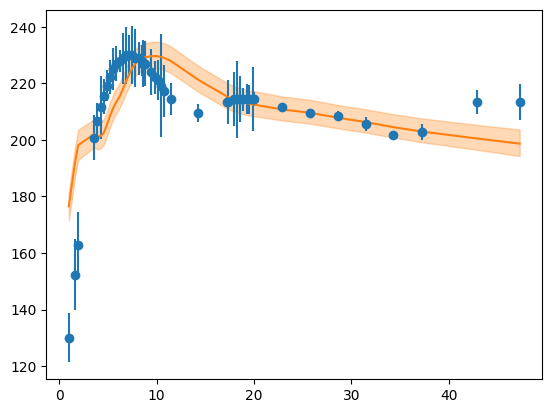

In [ ]:
ylow, ymed, yhigh = np.percentile(samples["Vpred"], [16, 50, 84], axis=0)

plt.figure()
plt.errorbar(np.median(samples["r"], axis=0), np.median(samples["Vobs"], axis=0), galaxy_data["e_Vobs"], fmt="o")
plt.plot(np.median(samples["r"], axis=0), ymed, color="C1")
plt.fill_between(np.median(samples["r"], axis=0), ylow, yhigh, color="C1", alpha=0.3)

plt.show()

ValueError: It looks like the parameter(s) in column(s) 1 have no dynamic range. Please provide a `range` argument.

Error in callback <function _draw_all_if_interactive at 0x7ae4547652d0> (for post_execute):


KeyboardInterrupt: 

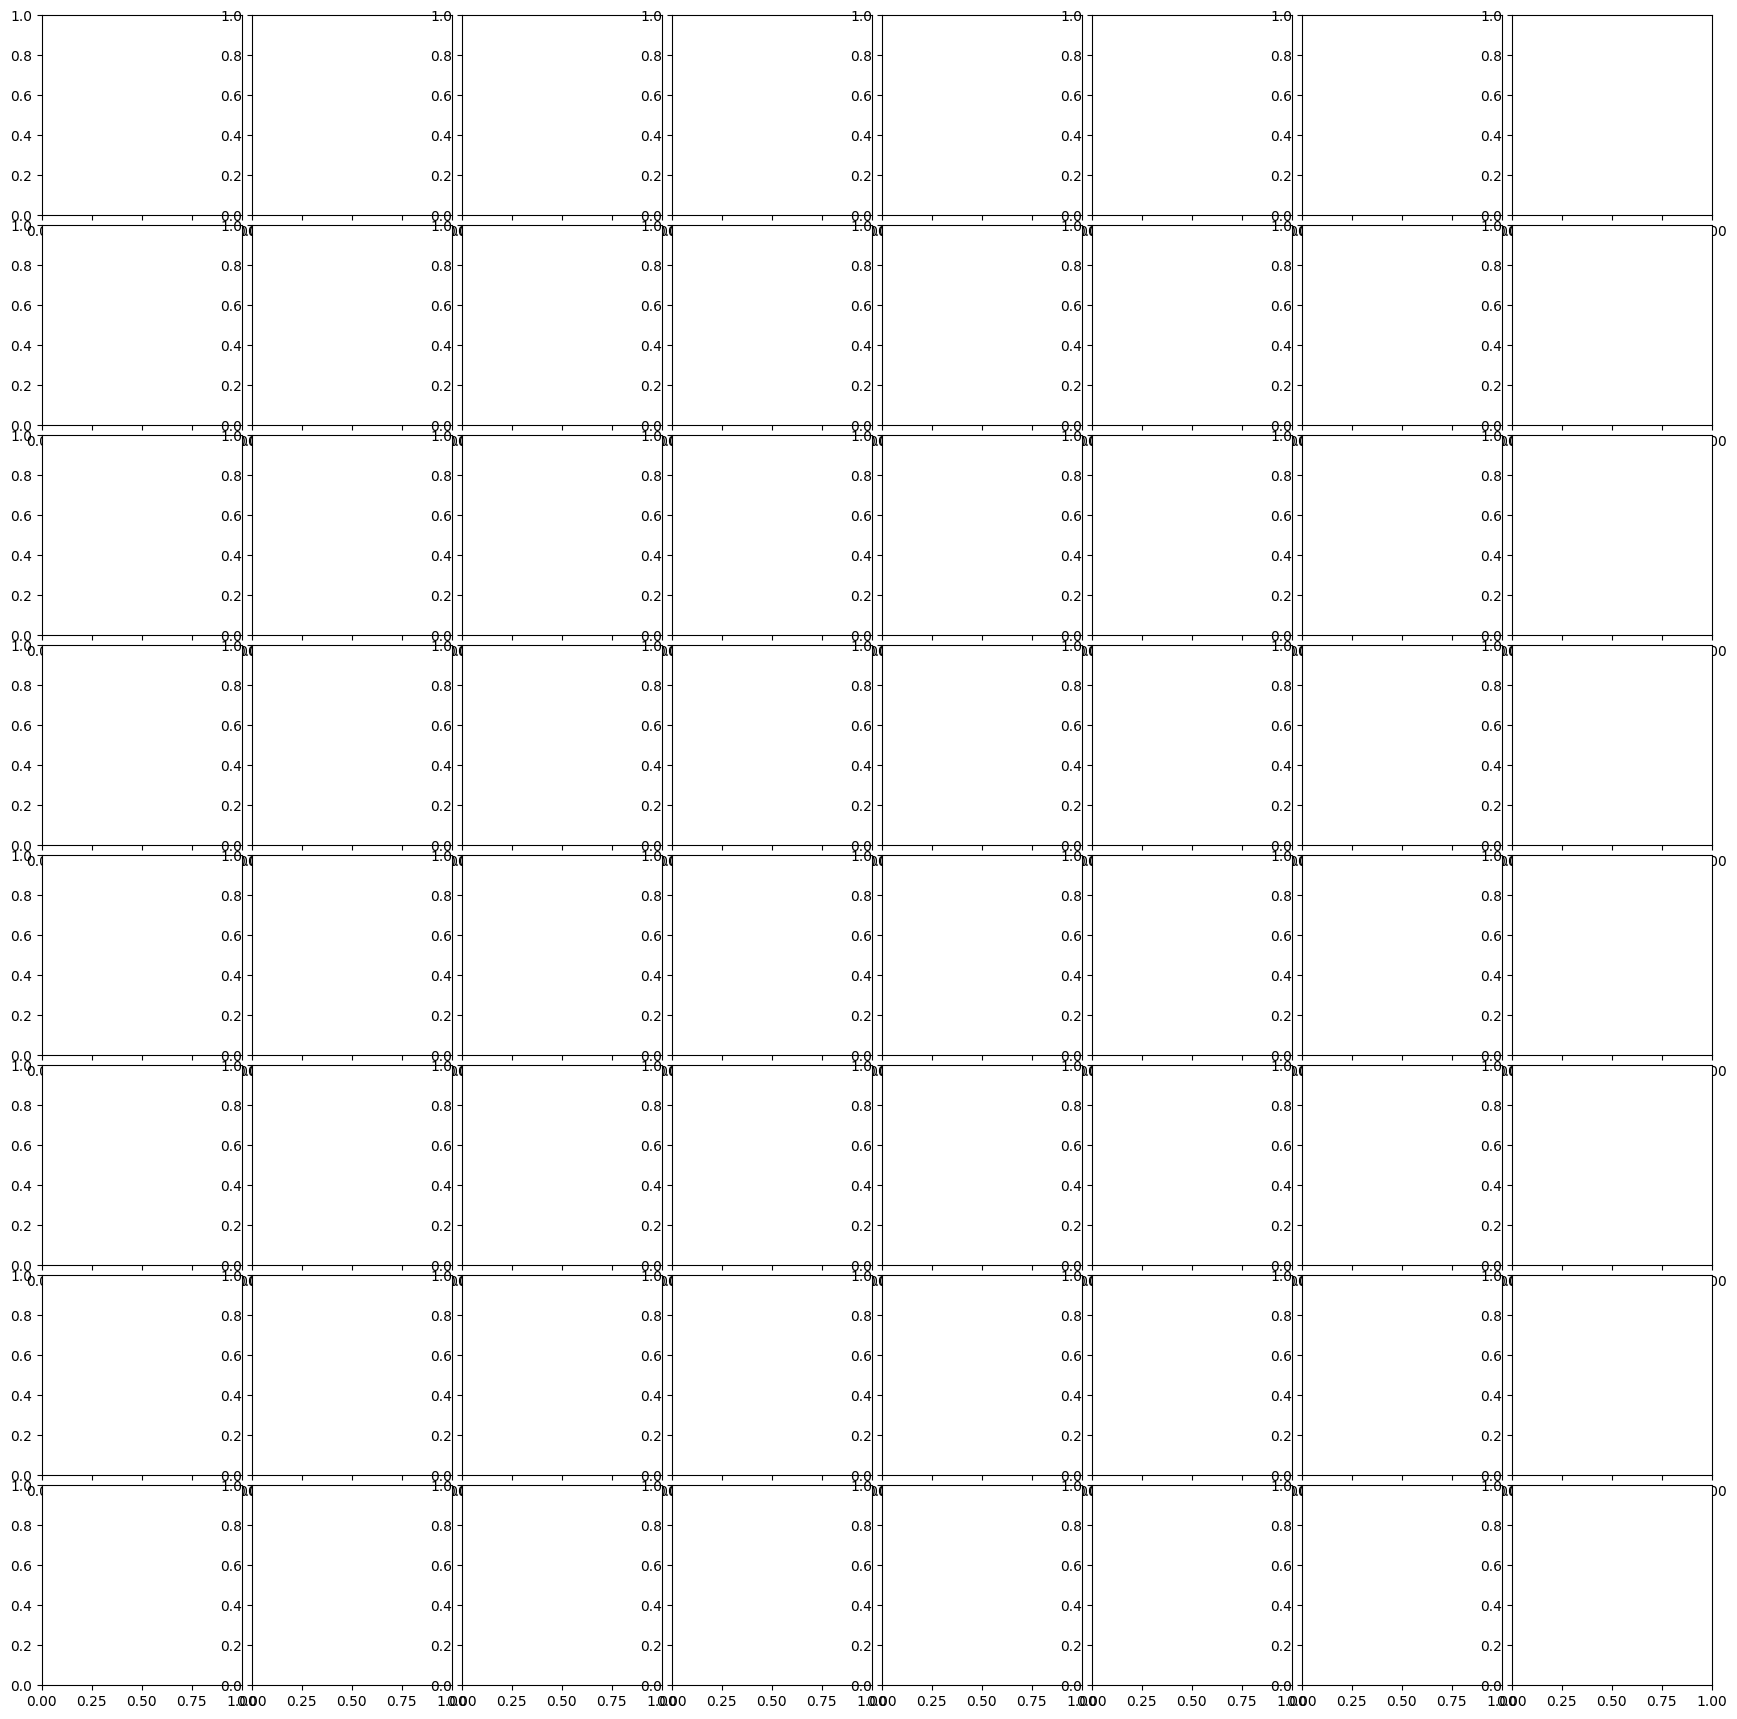

In [ ]:
fig = corner(dataNFW, labels=labels, show_titles=True, title_fmt=".3f", smooth=1)
fig.show()


In [ ]:
#BIC

#Minimum Loss calculator
ylow, ymed, yhigh = np.percentile(samples["Vpred"], [16, 50, 84], axis=0)

def lossFunc():
  vPred = ymed
  minLoss = np.sum((vPred - galaxy_data["Vobs"])**2 / galaxy_data["e_Vobs"]**2)
  return minLoss

lossFunc()

#Parameters
#NFW = 2 - 133389.42
#FDM = 5 - 133403.61
#CMOD = 2
#BUR = 2
#RAR = 2
#PISO = 2


def BICValue(parameters, r):

  #MinLossVal
  minLoss = lossFunc()

  k = parameters
  n = r.size
  return k * jnp.log(n) + 2 * minLoss

print(BICValue(2, galaxy_data["r"]))
#Lower values are better

133389.42


# Select Galaxy

In [ ]:
SelectedGalaxy = "UGC02916"

"""
UGC02953   113
UGC05253   72
NGC2403    72
UGC06787   68
UGC09133   67
UGC11914   61
NGC6946    54
NGC2841    50
UGC03205   46
NGC6015    44
UGC06786   41
UGC02916   41
UGC03580   39
UGC08699   38
NGC3198    37
NGC4013    36
NGC7331    36
UGC11455   35
NGC1003    35
NGC3521    34
NGC5985    33
NGC2903    32
IC4202     31
NGC6503    30
UGC08490   30
NGC4559    29
UGC12506   28
ESO563-G021 28
UGC07524   27
NGC5055    27
NGC0247    26
DDO161     26
NGC7793    25
NGC2955    24
NGC4100    24
NGC6195    23
NGC5585    23
NGC0289    22
UGC03546   22
IC2574     22
NGC5033    22
NGC1090    22
NGC3109    21
UGC00128   21
NGC2915    21
NGC2976    21
UGC05721   20
NGC4183    20
NGC0055    20
NGC0024    20
UGC09037   20
NGC5371    19
NGC5907    19
NGC3741    19
UGC02885   19
NGC4217    18
NGC0891    18
NGC7814    18
NGC5005    17
UGC02487   17
NGC4157    16
NGC0300    16
NGC0100    16
UGC08286   16
NGC3917    16
UGC12732   16
UGC05986   15
UGC06983   15
UGC04278   15
D631-7     14
NGC6674    14
UGC06446   14
ESO116-G012 14
UGC12632   13
NGC0801    13
NGC3726    12
ESO079-G014 12
UGC07125   12
F574-1     12
UGC00731   12
UGC07151   11
NGC4088    11
NGC3877    11
DDO154     11
NGC2683    11
UGC07603   11
UGC05716   11
UGC06917   11
F571-8     11
UGC08550   11
UGC06614   10
NGC3769    10
NGC3893    10
F583-1     10
NGC2998    10
UGC05764   10
UGC07399   10
NGC3972    9
NGC3992    9
UGC06930   9
UGC07089   9
DDO168     9
NGC4010    9
UGC04499   8
UGC04325   8
F583-4     8
KK98-251   8
UGC06667   8
NGC3953    8
UGC00191   8
F568-3     8
UGC07323   8
UGC02259   8
DDO170     7
UGCA442    7
UGC06399   7
UGC07690   7
NGC3949    6
UGC08837   6
NGC4051    6
UGC07261   6
UGC01281   6
UGC04483   6
UGC10310   6
NGC4085    6
ESO444-G084 6
UGC05414   5
UGC05829   5
UGC11820   5
F571-V1    5
D564-8     5
UGC06818   5
UGC06923   4
UGC11557   4
F568-V1    4
UGC05918   4
UGC00891   4
UGC00634   4
NGC4138    4
F565-V2    3
DDO064     3
UGC07232   2
UGC05750   2
NGC4068    2
CamB       2
NGC6789    1
D512-2     1
"""



'\nUGC02953   113\nUGC05253   72\nNGC2403    72\nUGC06787   68\nUGC09133   67\nUGC11914   61\nNGC6946    54\nNGC2841    50\nUGC03205   46\nNGC6015    44\nUGC06786   41\nUGC02916   41\nUGC03580   39\nUGC08699   38\nNGC3198    37\nNGC4013    36\nNGC7331    36\nUGC11455   35\nNGC1003    35\nNGC3521    34\nNGC5985    33\nNGC2903    32\nIC4202     31\nNGC6503    30\nUGC08490   30\nNGC4559    29\nUGC12506   28\nESO563-G021 28\nUGC07524   27\nNGC5055    27\nNGC0247    26\nDDO161     26\nNGC7793    25\nNGC2955    24\nNGC4100    24\nNGC6195    23\nNGC5585    23\nNGC0289    22\nUGC03546   22\nIC2574     22\nNGC5033    22\nNGC1090    22\nNGC3109    21\nUGC00128   21\nNGC2915    21\nNGC2976    21\nUGC05721   20\nNGC4183    20\nNGC0055    20\nNGC0024    20\nUGC09037   20\nNGC5371    19\nNGC5907    19\nNGC3741    19\nUGC02885   19\nNGC4217    18\nNGC0891    18\nNGC7814    18\nNGC5005    17\nUGC02487   17\nNGC4157    16\nNGC0300    16\nNGC0100    16\nUGC08286   16\nNGC3917    16\nUGC12732   16\nUGC05

# RC Models Calc

In [ ]:
  def name2label(name):
    """Convert parameter names to LaTeX labels."""
    x = {"L36": r"$L_{36}$",
         "dist": r"$d$",
         "inc": r"$i$",
         "logM200c": r"$\log M_{200c}$",
         "lUps_disk": r"$\log \Upsilon_{\rm disk}$",
         "lUps_gas": r"$\log \Upsilon_{\rm gas}$",
         "lUps_bulge": r"$\log \Upsilon_{\rm bulge}$",
         "logc": r"$\log c$",
         "a0": r"$a_0$",
         "alpha": r"$\alpha$",
         "beta": r"$\beta$",
         "gamma": r"$\gamma$",
         }

    try:
        return x[name]
    except KeyError:
        return name

  def M200c2R200c(M200c):
    """
    Convert M200c [Msun] to R200c [kpc] using the definition of the critical
    density `RHO200C`.
    """
    h = 0.7
    return (3 * M200c / (4 * np.pi * RHO200C * h**2))**(1./3)

def NFW_velocity_squared(r, M200c, c):
    """
    Calculate the circular velocity squared of an NFW profile at radius `r` for
    a halo with mass `M200c` and concentration `c`.
    """
    R200c = M200c2R200c(M200c)
    Rs = R200c / c
    return GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c))

def BUR_velocity_squared(r, M200c, c):
    """
    Calculate the circular velocity squared of an BUR profile at radius `r` for
    a halo with mass `M200c` and concentration `c`.
    """
    R200c = M200c2R200c(M200c)
    Rs = R200c / c
    return (GNEWTON * M200c * Rs / (4 * r)) * (jnp.log(( (r + Rs)**2 * (r**2 + Rs**2) )/ Rs**4) + 2*jnp.arctan(r / Rs))

def PISO_velocity_squared(r, M200c, c):
    """
    Calculate the circular velocity squared of an Pseudo Isothermal profile at radius `r` for
    a halo with mass `M200c` and concentration `c`.
    """
    R200c = M200c2R200c(M200c)
    Rs = R200c / c
    return (GNEWTON * M200c) * ( 1 -  (Rs/r) * jnp.arctan(r/Rs))

def FDM_velocity_squared(r, M200c, c, MAxion, alpha, rc):
    """
    Calculate the circular velocity squared of an FDM profile at radius `r` for
    a halo with mass `M200c` and concentration `c`, and Axion mass 'MAxion'.
    """
    R200c = M200c2R200c(M200c)
    Rs = R200c / c

    #Core Density
    #CoreDen = (1.9 * 10**10 * (MAxion*10**22)**(-2) * Rs**(-4))/((1+0.091*(x/Rs)**2)**8)

    #Solve for transR
    #x = Symbol("x")
    #transR = nsolve((1.9 * 10**10 * (MAxion*10**22)**(-2) * Rs**(-4))/((1+0.091*(x/Rs)**2)**8) -  (c)/((x/Rs) * (1 + x/Rs)**2), x, 1)
    #transR = nsolve((GNEWTON * Msol/x) - (GNEWTON * M200c / x * (jnp.log(1 + x / Rs) - x / (x + Rs)) / (jnp.log(1 + c) - c / (1 + c))), x, 2)

    #transR = alpha * Rs
    transR = alpha * rc
    #transR = 3*Rs
    #Msol = delta * 2.7*10**8 * MAxion**(-1) * (M200c)**(1/3)
    #Msol = 2.2*10**10 * MAxion*10**(-22) * Rs**(-4)
    Msol = 2.2*10**10 * MAxion*10**(-22) * rc**(-4)

    #return (4 * np.pi * (GNEWTON/x)) * ( (a * b**3 * 1000**8 * ((5115934091637369 * x**14 + 393533391664413000 * b**2 * x**12 + 12973628296629*10**6 * b**4 * x**10 + 237612239865*10**9 * b**6 * x**8 + 2611123515*10**12 * b**8 * x**6 + 17216199*10**15 * b**10 * x**4 + 63063*10**18 * b**12 * x**2 + 99*10**21 * b**14) * jnp.arctan((np.sqrt(91) * x) / (10**(3 / 2) * b)) + 99 * 10**(3 / 2) * 91**(13 / 2) * b * x**13 + 66 * 10**(11 / 2) * 91**(11 / 2) * b**3 * x**11 + 18678 * 10**(13 / 2) * 91**(9 / 2) * b**5 * x**9 + 2635776 * 10**(19 / 2) * 91**(5 / 2) * b**7 * x**7 + 26378 * 10**(25 / 2) * 91**(5 / 2) * b**9 * x**5 + 1388 * 10**(33 / 2) * 91**(3 / 2) * b**11 * x**3 - 99 * 10**(39 / 2) * np.sqrt(91) * b**13 * x)) / (6144 * 10**(39 / 2) * 91**(3 / 2) * (91 * x**2 + 1000 * b**2)**7) )*(transR - x) + (GNEWTON * M200c / x * (jnp.log(1 + x / Rs) - x / (x + Rs)) / (jnp.log(1 + c) - c / (1 + c)))*(x - transR)
    #return (GNEWTON * Msol/r)*((transR/r)/(transR/r + r/transR)) + (GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c)))*((r/transR)/(transR/r + r/transR))
    #return (GNEWTON * Msol/r) + (GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c)))
    #return jnp.piecewise(r, [r<= transR, r > transR], [lambda r: (GNEWTON * (Msol/r)), lambda r: (GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c)))])

    print(transR)
    return jnp.where(r<=transR, (GNEWTON * Msol/r), (GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c))))

    #f1 = GNEWTON * Msol/r
    #f2 = GNEWTON * M200c / r * (jnp.log(1 + r / Rs) - r / (r + Rs)) / (jnp.log(1 + c) - c / (1 + c))
    #return a*(transR-r) + f2*r

def BEC_velocity_squared(r, rho, omega, R):
    #R = 13.5 * (scatlen * 10**17)**(0,5) * (partmass * 10**36)**(-1.5)
    #Om2 = 0.02386 * (omega * 10**16)**2 * (rho * 10**24)**(-1)
    #Om2 = 0.02386 * (omega**2/ rho) * 10**8
    Om2 = 0.02386 * (omega**2/ rho)
    prR = jnp.pi * r/R

    #return 80.861 * (omega * 10**16) * R**2 * ( (1-Om2) * ((jnp.sin(prR))/prR) - (1-Om2) * jnp.cos(prR) + (Om2/3) * prR**2 )
    return 80.861 * (omega) * R**2 * ( (1-Om2) * ((jnp.sin(prR))/prR) - (1-Om2) * jnp.cos(prR) + (Om2/3) * prR**2 )

def CMOD_velocity_squared(r, M200c, c):
    """
    Calculate the circular velocity squared of an Core Modiefied profile at radius `r` for
    a halo with mass `M200c` and concentration `c`.
    """
    R200c = M200c2R200c(M200c)
    Rs = R200c / c
    return (GNEWTON * M200c) * ((Rs/(3*r)) * jnp.log((r**3 + Rs**3)/Rs**3))

def RAR(gbar, a0):
    return gbar / (1 - jnp.exp(-jnp.sqrt(gbar / a0)))


def RC_model(galaxy_data, kind):
    h = 0.7

    # Sample halo parameters
    if kind == "NFW":
        logM200c = numpyro.sample(
            "logM200c", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=12, scale=2)))  # noqa
        logc = numpyro.sample(
            "logc", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=0.905 - 0.101 * (logM200c - 12. + jnp.log10(h)), scale=0.11)))  # noqa
    elif kind == "BUR":
        logM200c = numpyro.sample(
            "logM200c", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=12, scale=2)))  # noqa
        logc = numpyro.sample("logc", dist.Uniform(-3, 3))  # noqa
    elif kind == "PISO":
        logM200c = numpyro.sample(
            "logM200c", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=12, scale=2)))  # noqa
        logc = numpyro.sample(
            "logc", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=0.905 - 0.101 * (logM200c - 12. + jnp.log10(h)), scale=0.11)))  # noqa
    elif kind == "FDM":
        logM200c = numpyro.sample(
            "logM200c", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=12, scale=2)))  # noqa
        logc = numpyro.sample(
            "logc", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=0.905 - 0.101 * (logM200c - 12. + jnp.log10(h)), scale=0.11)))  # noqa
        logMAxion = numpyro.sample("logMAxion", dist.Normal(20,26))
        alpha = numpyro.sample("alpha", dist.Normal(1,7))
        rc = numpyro.sample("rc", dist.Normal(0,2))
    elif kind == "BEC":
      #rho = numpyro.sample("rho", dist.Normal(-23,-25))
      #omega = numpyro.sample("omega", dist.Normal(-15,-17))
      #scatlen = numpyro.sample("scatlen", dist.Normal(20,26))
      #partmass = numpyro.sample("partmass", dist.Normal(20,26))
      rho = numpyro.sample("rho", dist.Normal(-2,2))
      omega = numpyro.sample("omega", dist.Normal(-2,2))
      R = numpyro.sample("R", dist.Normal(0,1))
    elif kind == "CMOD":
        logM200c = numpyro.sample(
            "logM200c", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=12, scale=2)))  # noqa
        logc = numpyro.sample(
            "logc", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=0.905 - 0.101 * (logM200c - 12. + jnp.log10(h)), scale=0.11)))  # noqa
    elif kind == "RAR":
        a0 = numpyro.sample("a0", dist.TruncatedNormal(1.19, 0.1, low=0.))
    else:
        raise ValueError(f"Unknown kind: `{kind}`.")



    # Sample mass-to-light ratios
    log_Ups_disk = numpyro.sample(
        "lUps_disk", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=jnp.log10(0.5), scale=0.1)))  # noqa
    log_Ups_bulge = numpyro.sample(
        "lUps_bulge", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=jnp.log10(0.7), scale=0.1)))  # noqa
    log_Ups_gas = numpyro.sample(
        "lUps_gas", dist.TransformedDistribution(dist.Normal(0, 1), AffineTransform(loc=jnp.log10(1.), scale=0.04)))  # noqa
    Ups_disk, Ups_bulge, Ups_gas = 10**log_Ups_disk, 10**log_Ups_bulge, 10**log_Ups_gas

    # Sample inclination and scale Vobs
    inc = numpyro.sample("inc", dist.TruncatedNormal(galaxy_data["inc"], galaxy_data["e_inc"], low=30 * np.pi / 180, high=150 * np.pi / 180))
    Vobs = numpyro.deterministic("Vobs", galaxy_data["Vobs"] * (jnp.sin(galaxy_data["inc"]) / jnp.sin(inc)))
    e_Vobs = galaxy_data["e_Vobs"] * (jnp.sin(galaxy_data["inc"]) / jnp.sin(inc))

    # Sample luminosity
    L36 = numpyro.sample("L36", dist.TruncatedNormal(galaxy_data["L36"], galaxy_data["e_L36"], low=0))
    Ups_disk *= L36 / galaxy_data["L36"]
    Ups_bulge *= L36 / galaxy_data["L36"]

    # Sample distance to the galaxy
    #galdist = numpyro.sample("dist", dist.TruncatedNormal(galaxy_data["dist"], galaxy_data["e_dist"], low=0))
    galdist = numpyro.deterministic("dist", galaxy_data["dist"])
    #galdist = numpyro.sample("galdist", dist.Normal(galaxy_data["dist"], galaxy_data["dist"]))
    Vbar_squared = Ups_disk * galaxy_data["Vdisk2"] + Ups_bulge * galaxy_data["Vbul2"] + Ups_gas * galaxy_data["Vgas2"]  # noqa
    Vbar_squared *= galdist / galaxy_data["dist"]

    # Calculate the DM contribution.
    r = numpyro.deterministic("r", galaxy_data["r"] * (galdist / galaxy_data["dist"]))
    if kind == "NFW":
        Vnfw_squared = NFW_velocity_squared(r, 10**logM200c, 10**logc)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vnfw_squared + Vbar_squared))
    elif kind == "RAR":
        # Convert a0 from 1e-10 m/s^2 to km^2 / s^2 / kpc
        gobs = RAR(Vbar_squared / r, 3085.6776 * a0)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(gobs * r))
    elif kind == "BUR":
        Vbur_squared = BUR_velocity_squared(r, 10**logM200c, 10**logc)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vbur_squared + Vbar_squared))
    elif kind == "PISO":
        Vpiso_squared = PISO_velocity_squared(r, 10**logM200c, 10**logc)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vpiso_squared + Vbar_squared))
    elif kind == "FDM":
        Vfdm_squared = FDM_velocity_squared(r, 10**logM200c, 10**logc, 10**logMAxion, alpha, rc)
        #Vfdm_squared = FDM_velocity_squared(r, 10**logM200c, 10**logc, 1.9, 3, 1 )
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vfdm_squared + Vbar_squared))
    elif kind == "BEC":
        Vbec_squared = BEC_velocity_squared(r, 10**rho, 10**omega, 10**R)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vbec_squared + Vbar_squared))
    elif kind == "CMOD":
        Vcmod_squared = CMOD_velocity_squared(r, 10**logM200c, 10**logc)
        Vpred = numpyro.deterministic("Vpred", jnp.sqrt(Vcmod_squared + Vbar_squared))
    else:
        raise ValueError(f"Unknown kind: `{kind}`.")

    with numpyro.plate("data", len(galaxy_data["r"]), dim=-1):
        numpyro.sample("obs", dist.Normal(Vpred, e_Vobs), obs=Vobs)


In [ ]:
galaxy_data = load_galaxy(SelectedGalaxy)

nuts_kernelNFW = NUTS(RC_model, init_strategy=init_to_median(num_samples=10000))
mcmcNFW = MCMC(nuts_kernelNFW, num_warmup=1000, num_samples=2000)
rng_keyNFW = random.PRNGKey(0)

mcmcNFW.run(rng_keyNFW, galaxy_data=galaxy_data, kind="NFW", extra_fields=("potential_energy",))

mcmcNFW.print_summary()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 369.24it/s, 63 steps of size 3.23e-02. acc. prob=0.92] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         L36    123.93      1.78    123.90    120.98    126.82   1872.36      1.00
         inc      1.01      0.07      1.01      0.90      1.12    873.47      1.00
  lUps_bulge     -0.43      0.04     -0.43     -0.49     -0.37    972.78      1.00
   lUps_disk     -0.23      0.10     -0.23     -0.39     -0.08   1273.91      1.00
    lUps_gas      0.00      0.04      0.00     -0.06      0.07   1244.23      1.00
    logM200c     11.70      0.10     11.71     11.54     11.87   1015.05      1.00
        logc      1.09      0.06      1.09      0.99      1.17   1180.76      1.00

Number of divergences: 0


In [ ]:
galaxy_data = load_galaxy(SelectedGalaxy)

nuts_kernelFDM = NUTS(RC_model, init_strategy=init_to_median(num_samples=10000))
mcmcFDM = MCMC(nuts_kernelFDM, num_warmup=1000, num_samples=2000)
rng_keyFDM = random.PRNGKey(0)

mcmcFDM.run(rng_keyFDM, galaxy_data=galaxy_data, kind="FDM", extra_fields=("potential_energy",))

mcmcFDM.print_summary()

-0.021708751
-0.029892322
Traced<ConcreteArray(-0.029892321676015854, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(-0.02989232, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7a53a18615b0>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>, Traced<ConcreteArray(-0.036753274500370026, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.8133240342140198, dtype=float32):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7a539592d760; to 'JaxprTracer' at 0x7a539592ede0>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[] c:f32[] d:f32[]. let
    e:f32[] = mul a c
    f:f32[] = mul d b
    g:f32[] = add_any e f
  in (g,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedVal

  0%|          | 0/3000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[])>with<JVPTrace(level=5/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=4/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7a5399c45130>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>), out_tracer_refs=[<weakref at 0x7a53a1911210; to 'JaxprTracer' at 0x7a53a1910e50>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[] c:f32[] d:f32[]. let
    e:f32[] = mul a c
    f:f32[] = mul d b
    g:f32[] = add_any e f
  in (g,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue, UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invar

sample: 100%|██████████| 3000/3000 [00:18<00:00, 166.22it/s, 1023 steps of size 6.53e-04. acc. prob=0.67]


Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         L36    123.19      2.38    123.47    119.59    127.58      8.68      1.09
       alpha      4.73      2.63      4.22      1.43      8.80      2.57      2.55
         inc      1.01      0.06      1.01      0.90      1.09      6.70      1.23
  lUps_bulge     -0.48      0.04     -0.49     -0.53     -0.42      3.87      1.66
   lUps_disk      0.02      0.06      0.01     -0.07      0.11     34.08      1.02
    lUps_gas     -0.02      0.04     -0.02     -0.08      0.04     34.30      1.02
    logM200c     11.39      0.12     11.36     11.22     11.59      3.92      1.38
   logMAxion     21.90      1.06     21.77     20.43     23.43      2.48      2.68
        logc      1.21      0.04      1.21      1.14      1.27     14.35      1.06
          rc      1.58      0.92      1.22      0.51      3.00      2.61      2.40

Number of divergence

In [ ]:
galaxy_data = load_galaxy(SelectedGalaxy)

nuts_kernelCMOD = NUTS(RC_model, init_strategy=init_to_median(num_samples=10000))
mcmcCMOD = MCMC(nuts_kernelCMOD, num_warmup=1000, num_samples=2000)
rng_keyCMOD = random.PRNGKey(0)

mcmcCMOD.run(rng_keyCMOD, galaxy_data=galaxy_data, kind="CMOD", extra_fields=("potential_energy",))

mcmcCMOD.print_summary()

sample: 100%|██████████| 3000/3000 [00:07<00:00, 407.18it/s, 255 steps of size 2.47e-02. acc. prob=0.94]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         L36    123.75      1.85    123.81    120.50    126.57   1429.06      1.00
         inc      0.89      0.07      0.89      0.79      1.01    426.74      1.00
  lUps_bulge     -0.27      0.05     -0.27     -0.35     -0.19    396.20      1.00
   lUps_disk     -0.48      0.08     -0.48     -0.61     -0.34   1228.91      1.00
    lUps_gas     -0.01      0.04     -0.01     -0.07      0.05   1482.57      1.00
    logM200c     10.25      0.06     10.24     10.14     10.34    439.60      1.00
        logc      0.87      0.02      0.86      0.83      0.90    415.86      1.00

Number of divergences: 0


In [ ]:
galaxy_data = load_galaxy(SelectedGalaxy)

nuts_kernelRAR = NUTS(RC_model, init_strategy=init_to_median(num_samples=10000))
mcmcRAR = MCMC(nuts_kernelRAR, num_warmup=1000, num_samples=2000)
rng_keyRAR = random.PRNGKey(0)

mcmcRAR.run(rng_keyRAR, galaxy_data=galaxy_data, kind="RAR", extra_fields=("potential_energy",))

mcmcRAR.print_summary()

sample: 100%|██████████| 3000/3000 [00:07<00:00, 414.60it/s, 127 steps of size 3.69e-02. acc. prob=0.94] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         L36    124.46      1.80    124.44    121.59    127.33   1258.01      1.00
          a0      1.00      0.11      1.00      0.82      1.16   1075.02      1.00
         inc      0.83      0.04      0.82      0.75      0.89    650.91      1.00
  lUps_bulge     -0.26      0.04     -0.26     -0.32     -0.20    653.05      1.00
   lUps_disk      0.02      0.06      0.03     -0.08      0.13    682.03      1.00
    lUps_gas     -0.06      0.04     -0.06     -0.12      0.01   1320.80      1.00

Number of divergences: 0


In [ ]:
galaxy_data = load_galaxy(SelectedGalaxy)

nuts_kernelPISO = NUTS(RC_model, init_strategy=init_to_median(num_samples=10000))
mcmcPISO = MCMC(nuts_kernelPISO, num_warmup=1000, num_samples=2000)
rng_keyPISO = random.PRNGKey(0)

mcmcPISO.run(rng_keyPISO, galaxy_data=galaxy_data, kind="PISO", extra_fields=("potential_energy",))

mcmcPISO.print_summary()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 363.32it/s, 127 steps of size 2.82e-02. acc. prob=0.94]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         L36    123.41      1.80    123.38    120.48    126.32   1883.26      1.00
         inc      0.94      0.07      0.94      0.83      1.06    696.64      1.00
  lUps_bulge     -0.75      0.04     -0.75     -0.82     -0.67   1065.34      1.00
   lUps_disk     -0.34      0.07     -0.34     -0.45     -0.21   1357.01      1.00
    lUps_gas     -0.01      0.04     -0.01     -0.08      0.05   1413.48      1.00
    logM200c      9.84      0.06      9.84      9.73      9.95    811.86      1.00
        logc      2.24      0.06      2.24      2.14      2.33   1569.41      1.00

Number of divergences: 0


In [ ]:
galaxy_data = load_galaxy(SelectedGalaxy)

nuts_kernelBUR = NUTS(RC_model, init_strategy=init_to_median(num_samples=10000))
mcmcBUR = MCMC(nuts_kernelBUR, num_warmup=1000, num_samples=2000)
rng_keyBUR = random.PRNGKey(0)

mcmcBUR.run(rng_keyBUR, galaxy_data=galaxy_data, kind="BUR", extra_fields=("potential_energy",))

mcmcBUR.print_summary()

sample: 100%|██████████| 3000/3000 [00:11<00:00, 268.76it/s, 255 steps of size 1.71e-02. acc. prob=0.94]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         L36    123.41      1.83    123.45    120.55    126.54   1495.78      1.00
         inc      0.82      0.07      0.81      0.70      0.94    926.40      1.00
  lUps_bulge     -0.89      0.06     -0.89     -0.99     -0.79    989.65      1.00
   lUps_disk     -0.18      0.06     -0.18     -0.27     -0.07   1130.96      1.00
    lUps_gas      0.01      0.04      0.01     -0.06      0.07   1357.95      1.00
    logM200c      9.95      0.07      9.95      9.83     10.06    969.17      1.00
        logc      0.30      0.10      0.32      0.16      0.46    613.08      1.00

Number of divergences: 0


In [ ]:
galaxy_data = load_galaxy(SelectedGalaxy)

nuts_kernelBEC = NUTS(RC_model, init_strategy=init_to_median(num_samples=10000))
mcmcBEC = MCMC(nuts_kernelBEC, num_warmup=1000, num_samples=2000)
rng_keyBEC = random.PRNGKey(0)

mcmcBEC.run(rng_keyBEC, galaxy_data=galaxy_data, kind="BEC", extra_fields=("potential_energy",))

mcmcBEC.print_summary()

sample: 100%|██████████| 3000/3000 [00:08<00:00, 353.04it/s, 127 steps of size 3.97e-02. acc. prob=0.95] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         L36    124.19      1.82    124.21    121.19    127.10   1723.64      1.00
           R      1.20      0.02      1.20      1.17      1.24   1241.48      1.00
         inc      1.12      0.06      1.12      1.02      1.23    819.65      1.00
  lUps_bulge     -0.41      0.03     -0.41     -0.46     -0.36    790.15      1.00
   lUps_disk     -0.03      0.05     -0.02     -0.12      0.06   1184.71      1.00
    lUps_gas      0.04      0.04      0.04     -0.02      0.12   1550.80      1.00
       omega     -0.31      0.07     -0.31     -0.43     -0.20    864.85      1.00
         rho     -1.19      0.16     -1.19     -1.44     -0.91    778.70      1.00

Number of divergences: 0


In [ ]:
samplesNFW = mcmcNFW.get_samples()

labelsNFW = list(samplesNFW.keys())
for p in ("Vpred", "Vobs", "r", "dist"):
    try:
        labelsNFW.remove(p)
    except ValueError:
        pass
# [labels.remove(p) for p in ("Vpred", "Vobs", "r")]
dataNFW = np.vstack([samplesNFW[label] for label in labelsNFW]).T



In [ ]:
samplesFDM = mcmcFDM.get_samples()

labelsFDM = list(samplesFDM.keys())
for p in ("Vpred", "Vobs", "r", "dist"):
    try:
        labelsFDM.remove(p)
    except ValueError:
        pass
# [labels.remove(p) for p in ("Vpred", "Vobs", "r")]
dataFDM = np.vstack([samplesFDM[label] for label in labelsFDM]).T

In [ ]:
samplesRAR = mcmcRAR.get_samples()

labelsRAR = list(samplesRAR.keys())
for p in ("Vpred", "Vobs", "r", "dist"):
    try:
        labelsRAR.remove(p)
    except ValueError:
        pass
# [labels.remove(p) for p in ("Vpred", "Vobs", "r")]
dataRAR = np.vstack([samplesRAR[label] for label in labelsRAR]).T

In [ ]:
samplesCMOD = mcmcCMOD.get_samples()

labelsCMOD = list(samplesCMOD.keys())
for p in ("Vpred", "Vobs", "r", "dist"):
    try:
        labelsCMOD.remove(p)
    except ValueError:
        pass
# [labels.remove(p) for p in ("Vpred", "Vobs", "r")]
dataCMOD = np.vstack([samplesCMOD[label] for label in labelsCMOD]).T

In [ ]:
samplesBUR = mcmcBUR.get_samples()

labelsBUR = list(samplesBUR.keys())
for p in ("Vpred", "Vobs", "r", "dist"):
    try:
        labelsBUR.remove(p)
    except ValueError:
        pass
# [labels.remove(p) for p in ("Vpred", "Vobs", "r")]
dataBUR = np.vstack([samplesBUR[label] for label in labelsBUR]).T

In [ ]:
samplesPISO = mcmcPISO.get_samples()

labelsPISO = list(samplesPISO.keys())
for p in ("Vpred", "Vobs", "r", "dist"):
    try:
        labelsPISO.remove(p)
    except ValueError:
        pass
# [labels.remove(p) for p in ("Vpred", "Vobs", "r")]
dataPISO = np.vstack([samplesPISO[label] for label in labelsPISO]).T

In [ ]:
samplesBEC = mcmcBEC.get_samples()

labelsBEC = list(samplesBEC.keys())
for p in ("Vpred", "Vobs", "r", "dist"):
    try:
        labelsBEC.remove(p)
    except ValueError:
        pass
# [labels.remove(p) for p in ("Vpred", "Vobs", "r")]
dataBEC = np.vstack([samplesBEC[label] for label in labelsBEC]).T

# RC Results

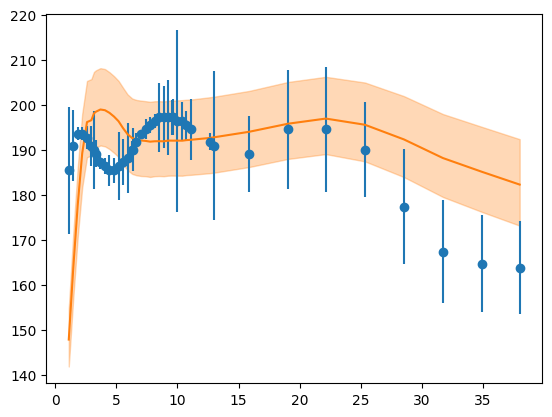

In [ ]:
ylow, ymed, yhigh = np.percentile(samplesNFW["Vpred"], [16, 50, 84], axis=0)

plt.figure()
plt.errorbar(np.median(samplesNFW["r"], axis=0), np.median(samplesNFW["Vobs"], axis=0), galaxy_data["e_Vobs"], fmt="o")
plt.plot(np.median(samplesNFW["r"], axis=0), ymed, color="C1")
plt.fill_between(np.median(samplesNFW["r"], axis=0), ylow, yhigh, color="C1", alpha=0.3)

plt.show()

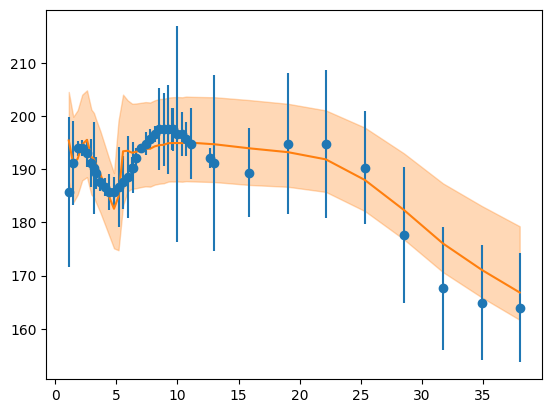

In [ ]:
ylow, ymed, yhigh = np.percentile(samplesFDM["Vpred"], [16, 50, 84], axis=0)

plt.figure()
plt.errorbar(np.median(samplesFDM["r"], axis=0), np.median(samplesFDM["Vobs"], axis=0), galaxy_data["e_Vobs"], fmt="o")
plt.plot(np.median(samplesFDM["r"], axis=0), ymed, color="C1")
plt.fill_between(np.median(samplesFDM["r"], axis=0), ylow, yhigh, color="C1", alpha=0.3)

plt.show()

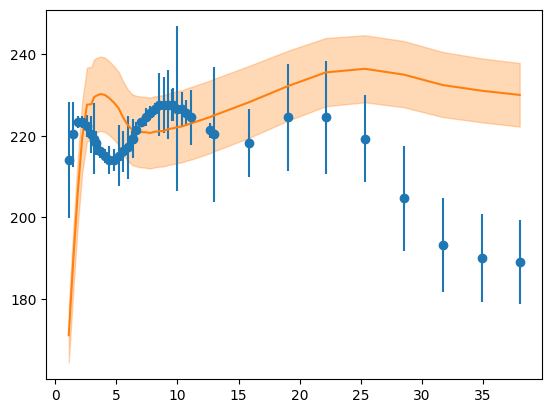

In [ ]:
ylow, ymed, yhigh = np.percentile(samplesRAR["Vpred"], [16, 50, 84], axis=0)

plt.figure()
plt.errorbar(np.median(samplesRAR["r"], axis=0), np.median(samplesRAR["Vobs"], axis=0), galaxy_data["e_Vobs"], fmt="o")
plt.plot(np.median(samplesRAR["r"], axis=0), ymed, color="C1")
plt.fill_between(np.median(samplesRAR["r"], axis=0), ylow, yhigh, color="C1", alpha=0.3)

plt.show()

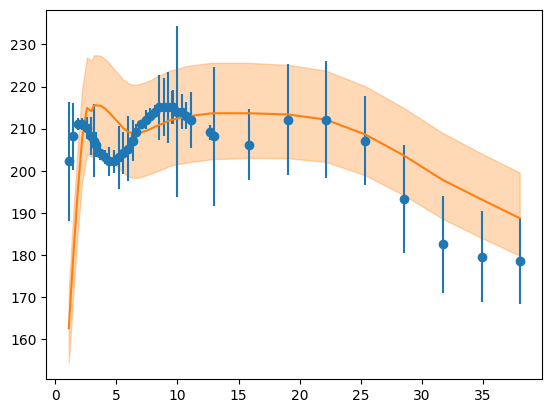

In [ ]:
ylow, ymed, yhigh = np.percentile(samplesCMOD["Vpred"], [16, 50, 84], axis=0)

plt.figure()
plt.errorbar(np.median(samplesCMOD["r"], axis=0), np.median(samplesCMOD["Vobs"], axis=0), galaxy_data["e_Vobs"], fmt="o")
plt.plot(np.median(samplesCMOD["r"], axis=0), ymed, color="C1")
plt.fill_between(np.median(samplesCMOD["r"], axis=0), ylow, yhigh, color="C1", alpha=0.3)

plt.show()

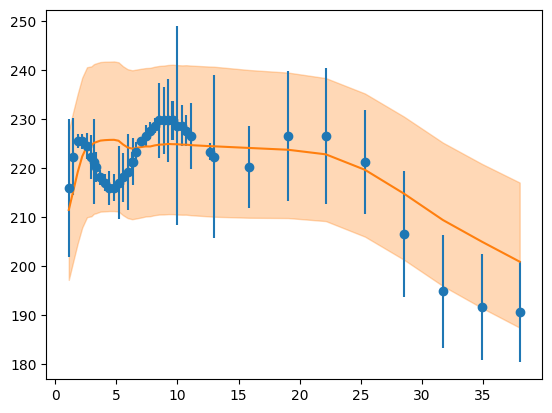

In [ ]:
ylow, ymed, yhigh = np.percentile(samplesBUR["Vpred"], [16, 50, 84], axis=0)

plt.figure()
plt.errorbar(np.median(samplesBUR["r"], axis=0), np.median(samplesBUR["Vobs"], axis=0), galaxy_data["e_Vobs"], fmt="o")
plt.plot(np.median(samplesBUR["r"], axis=0), ymed, color="C1")
plt.fill_between(np.median(samplesBUR["r"], axis=0), ylow, yhigh, color="C1", alpha=0.3)

plt.show()

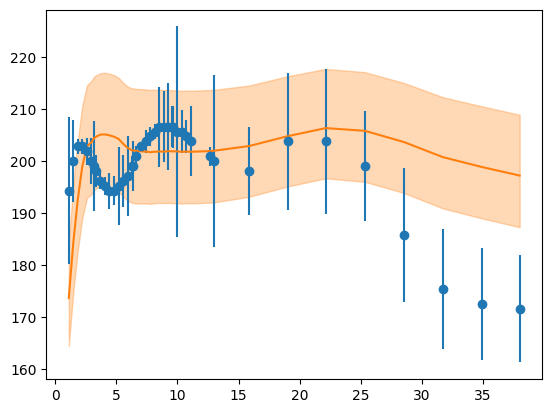

In [ ]:
ylow, ymed, yhigh = np.percentile(samplesPISO["Vpred"], [16, 50, 84], axis=0)

plt.figure()
plt.errorbar(np.median(samplesPISO["r"], axis=0), np.median(samplesPISO["Vobs"], axis=0), galaxy_data["e_Vobs"], fmt="o")
plt.plot(np.median(samplesPISO["r"], axis=0), ymed, color="C1")
plt.fill_between(np.median(samplesPISO["r"], axis=0), ylow, yhigh, color="C1", alpha=0.3)

plt.show()

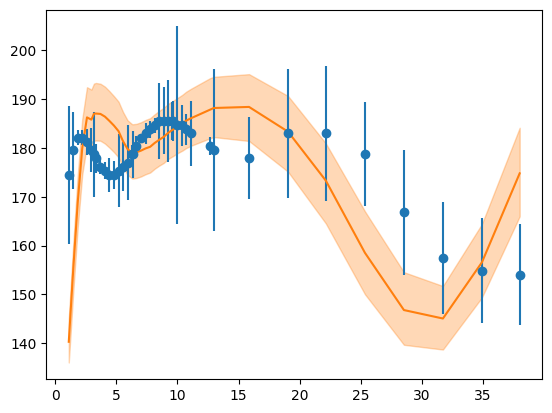

In [ ]:
ylow, ymed, yhigh = np.percentile(samplesBEC["Vpred"], [16, 50, 84], axis=0)

plt.figure()
plt.errorbar(np.median(samplesBEC["r"], axis=0), np.median(samplesBEC["Vobs"], axis=0), galaxy_data["e_Vobs"], fmt="o")
plt.plot(np.median(samplesBEC["r"], axis=0), ymed, color="C1")
plt.fill_between(np.median(samplesBEC["r"], axis=0), ylow, yhigh, color="C1", alpha=0.3)

plt.show()

# Corner Plots

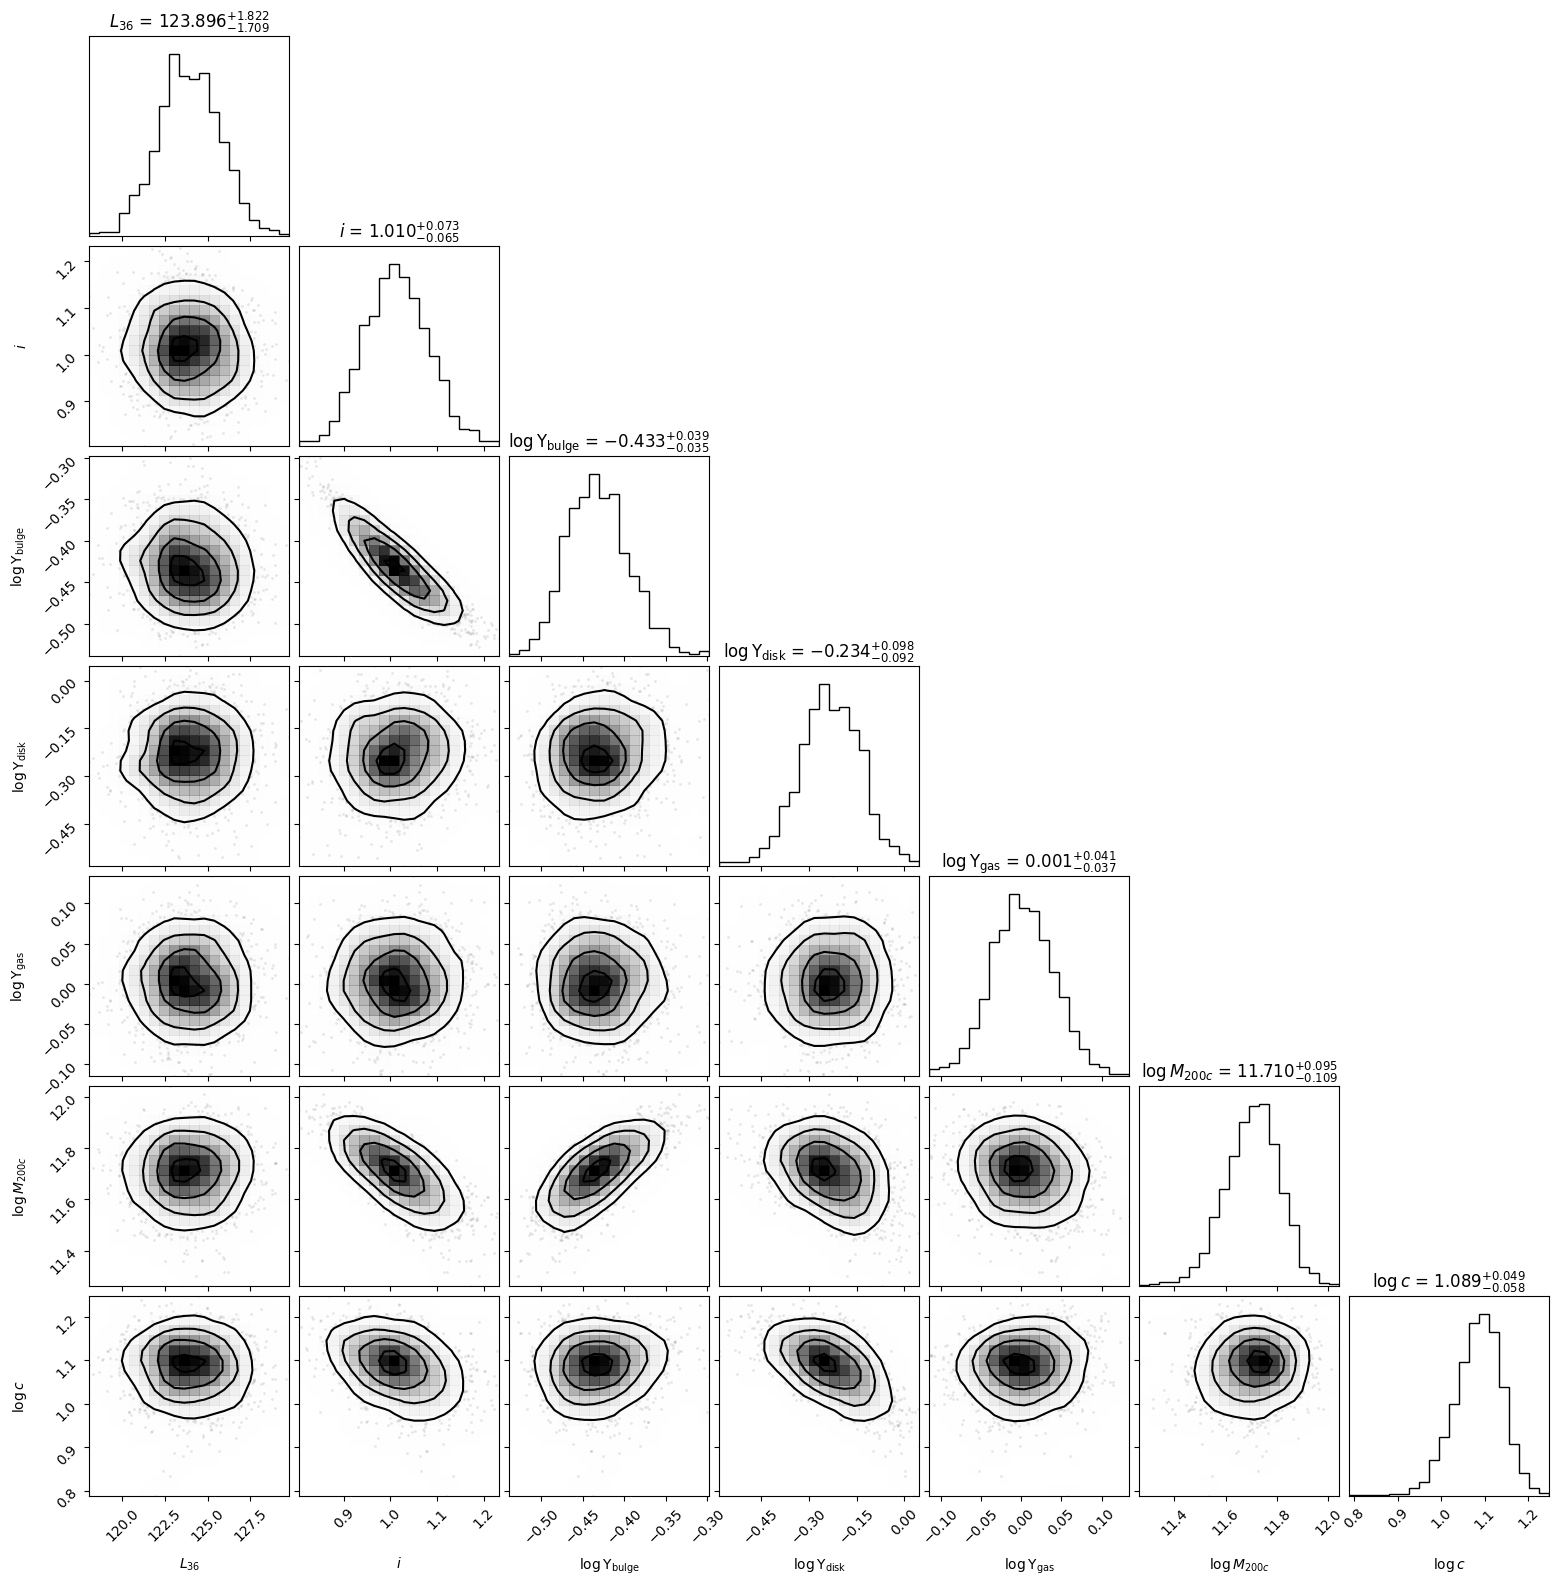

In [ ]:
current_labels = [name2label(name) for name in labelsNFW]
fig = corner(dataNFW, labels=current_labels, show_titles=True, title_fmt=".3f", smooth=1)

fig.show()



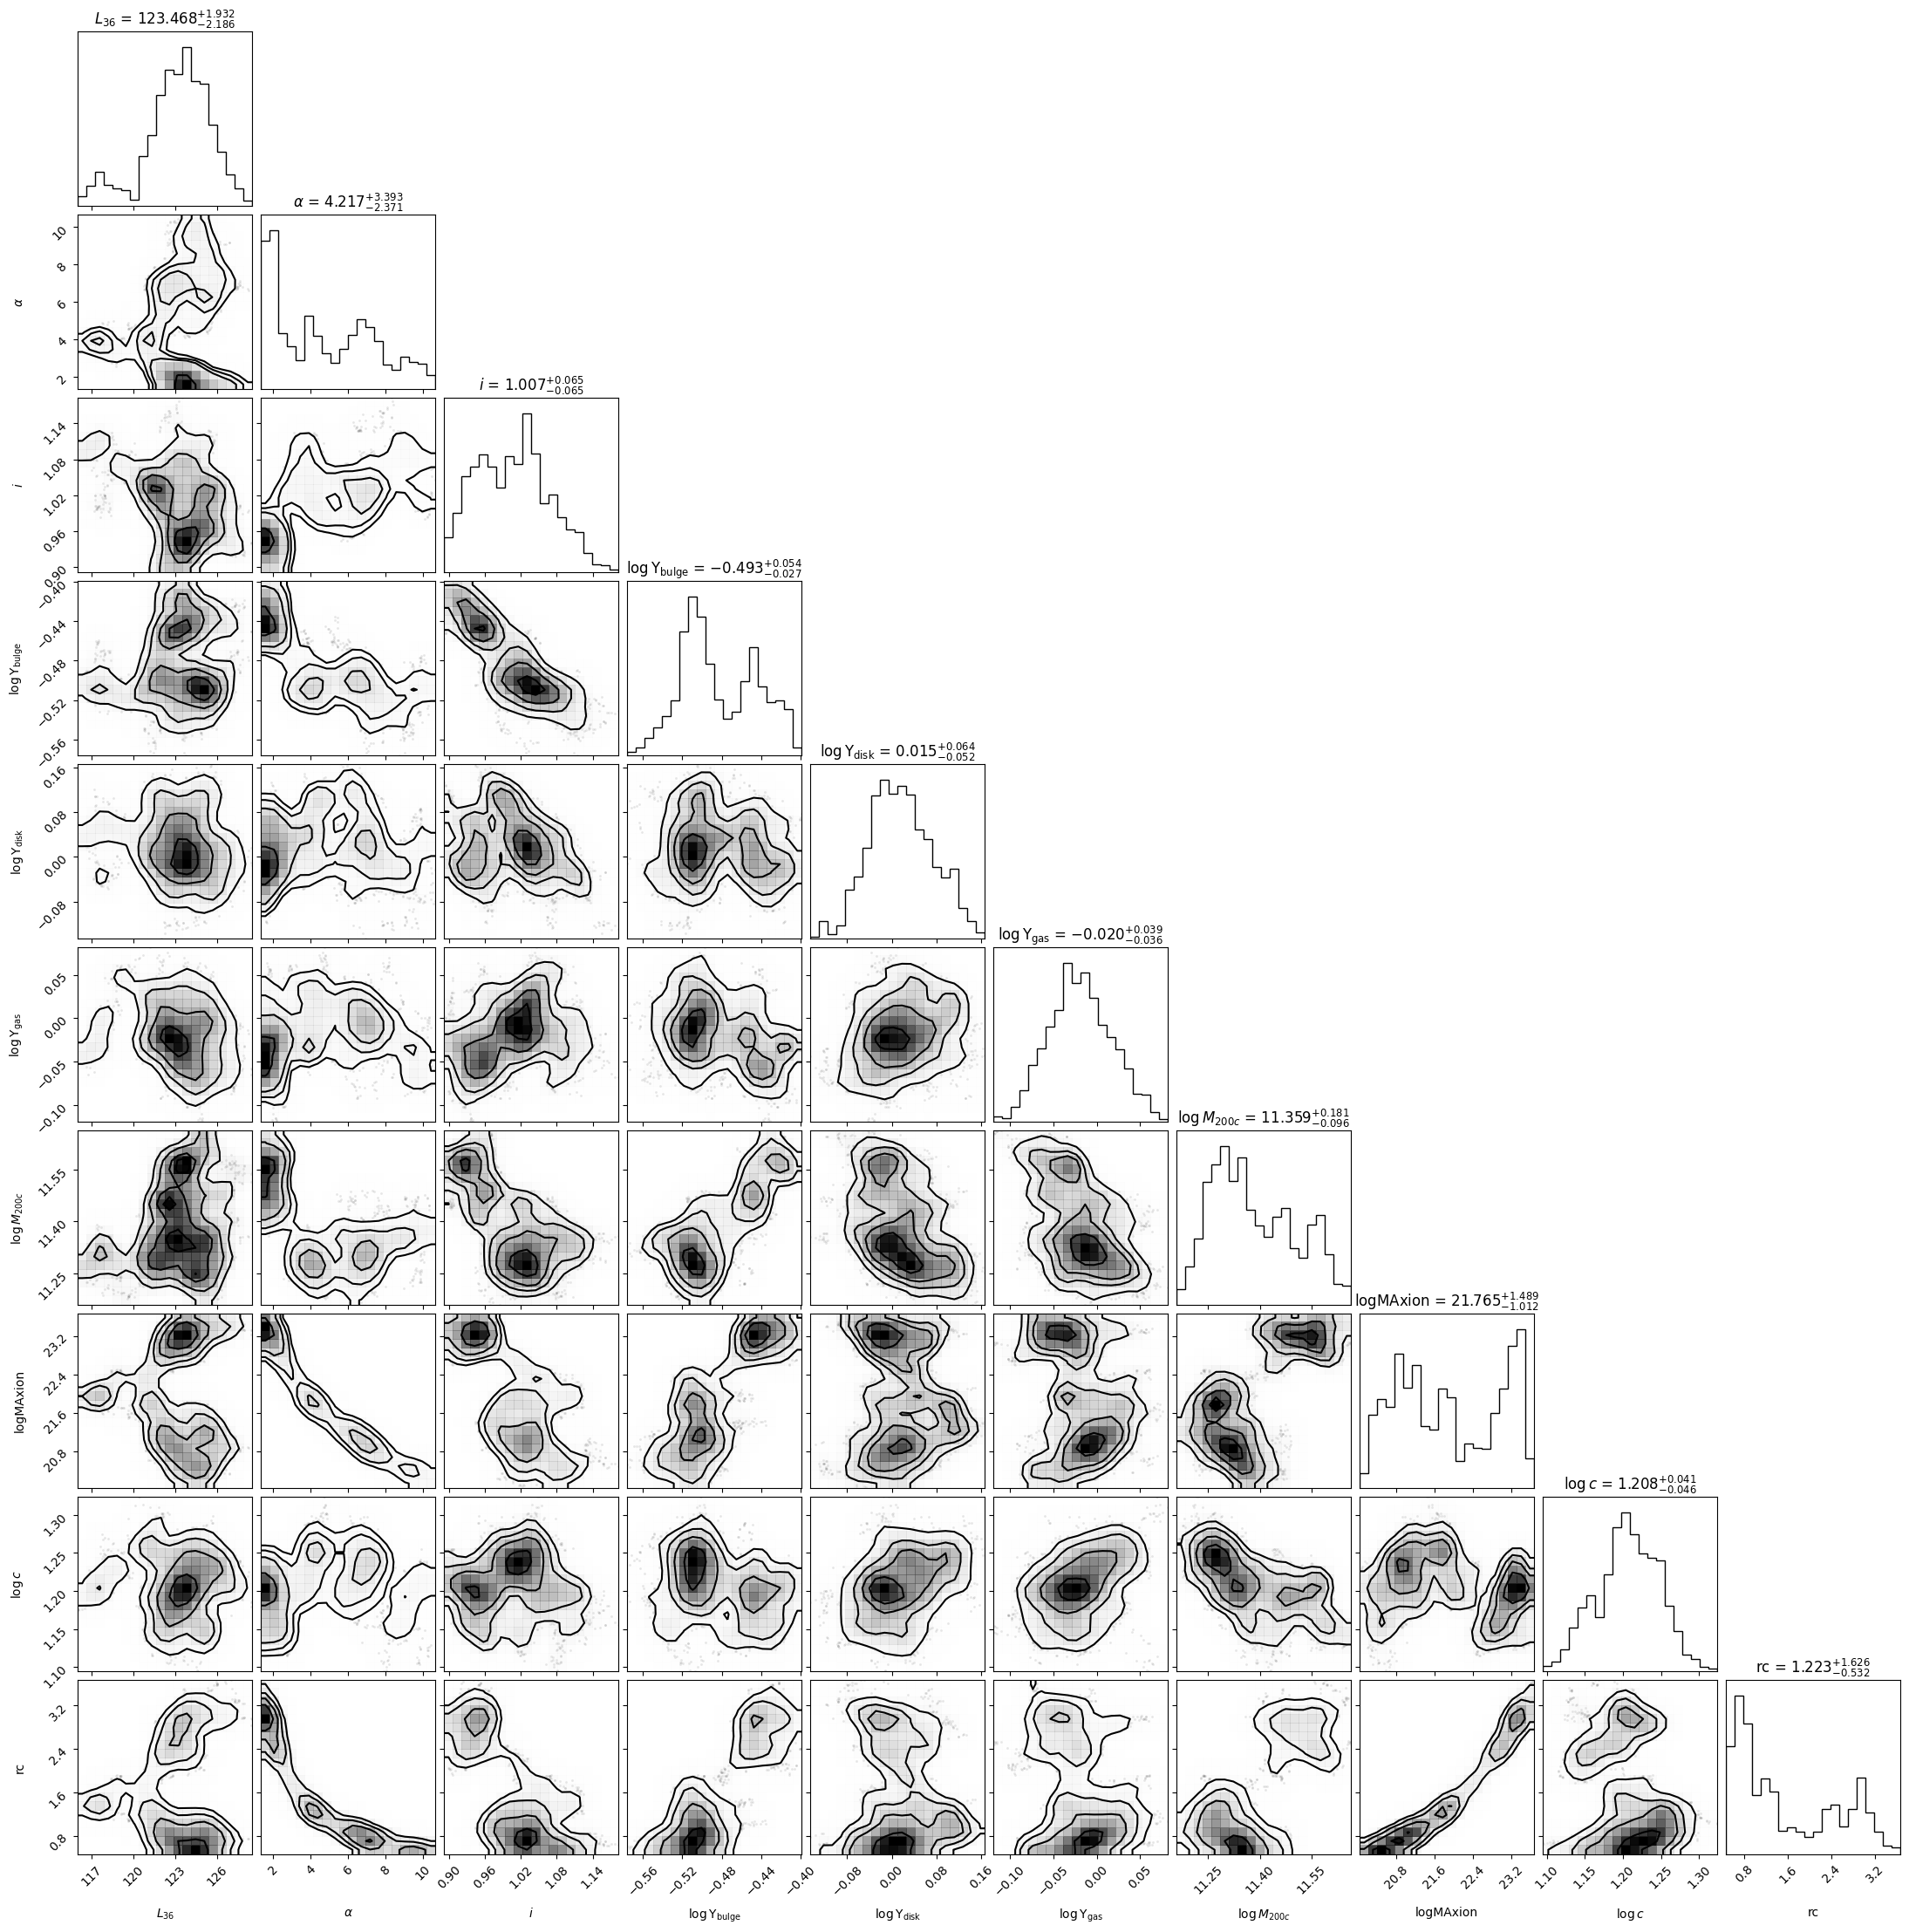

In [ ]:
current_labels = [name2label(name) for name in labelsFDM]
fig = corner(dataFDM, labels=current_labels, show_titles=True, title_fmt=".3f", smooth=1)
fig.show()


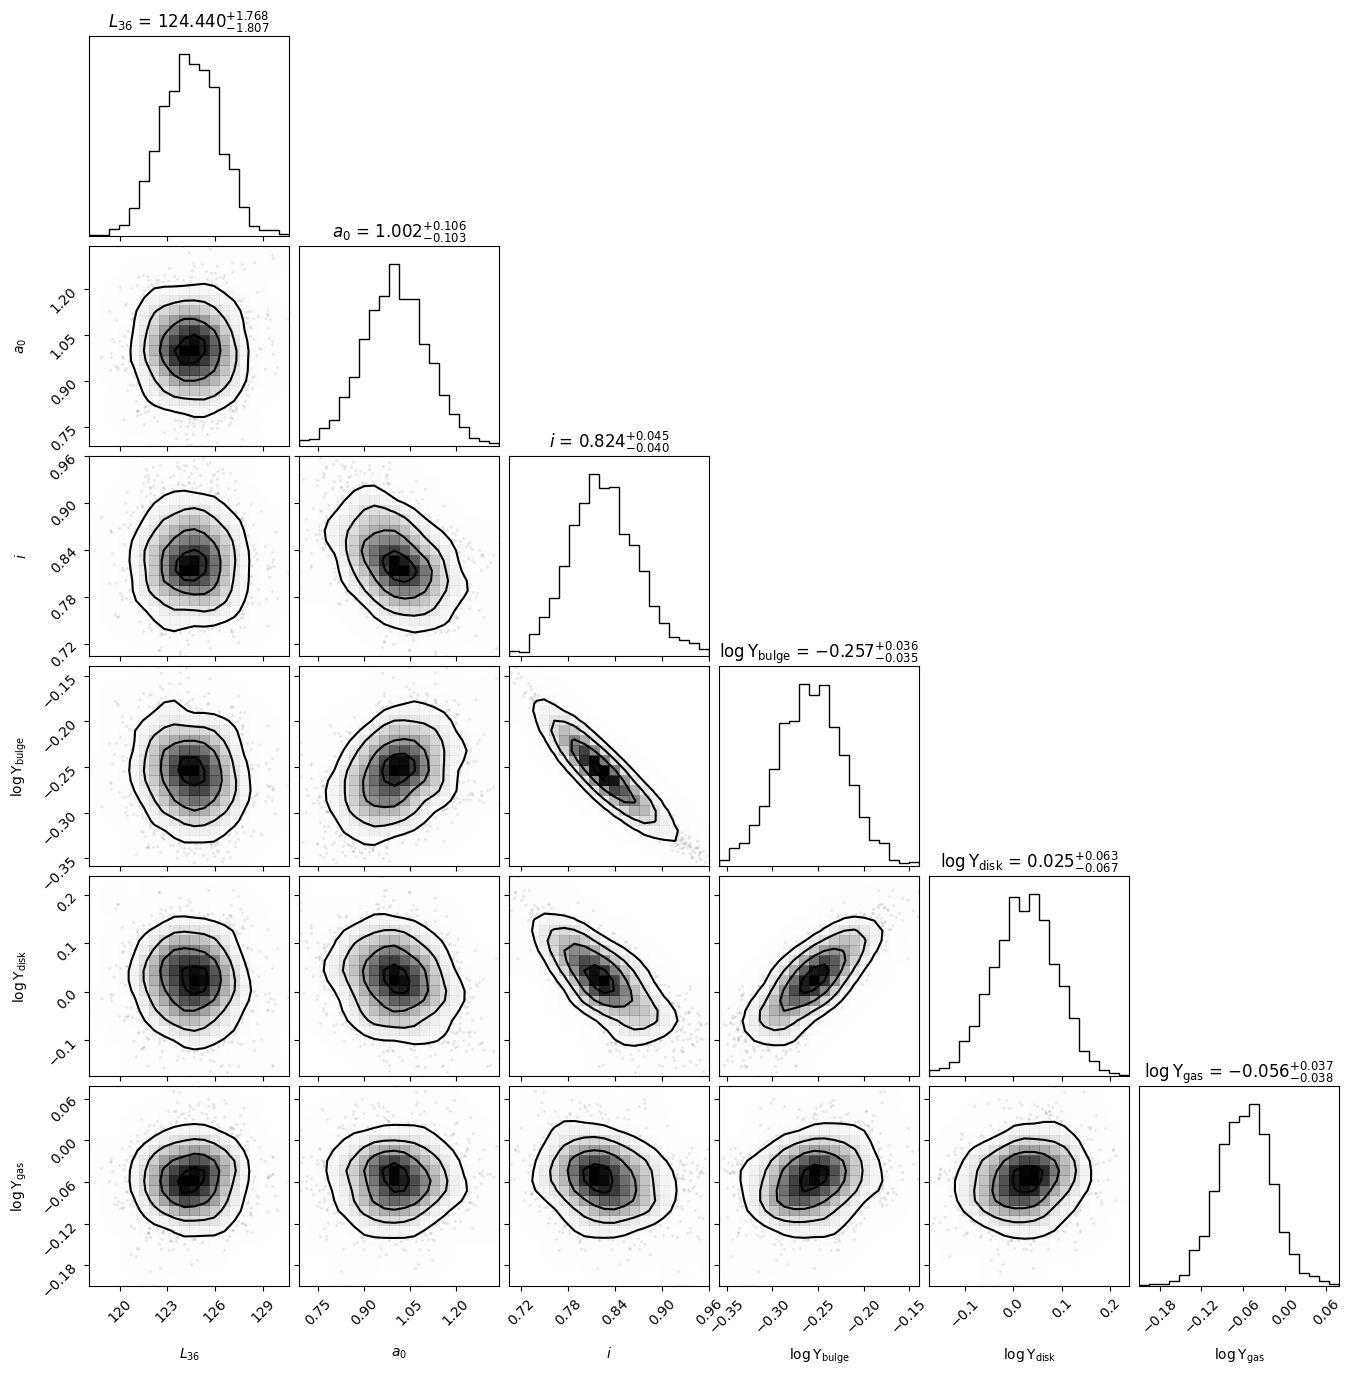

In [ ]:
current_labels = [name2label(name) for name in labelsRAR]
fig = corner(dataRAR, labels=current_labels, show_titles=True, title_fmt=".3f", smooth=1)
fig.show()


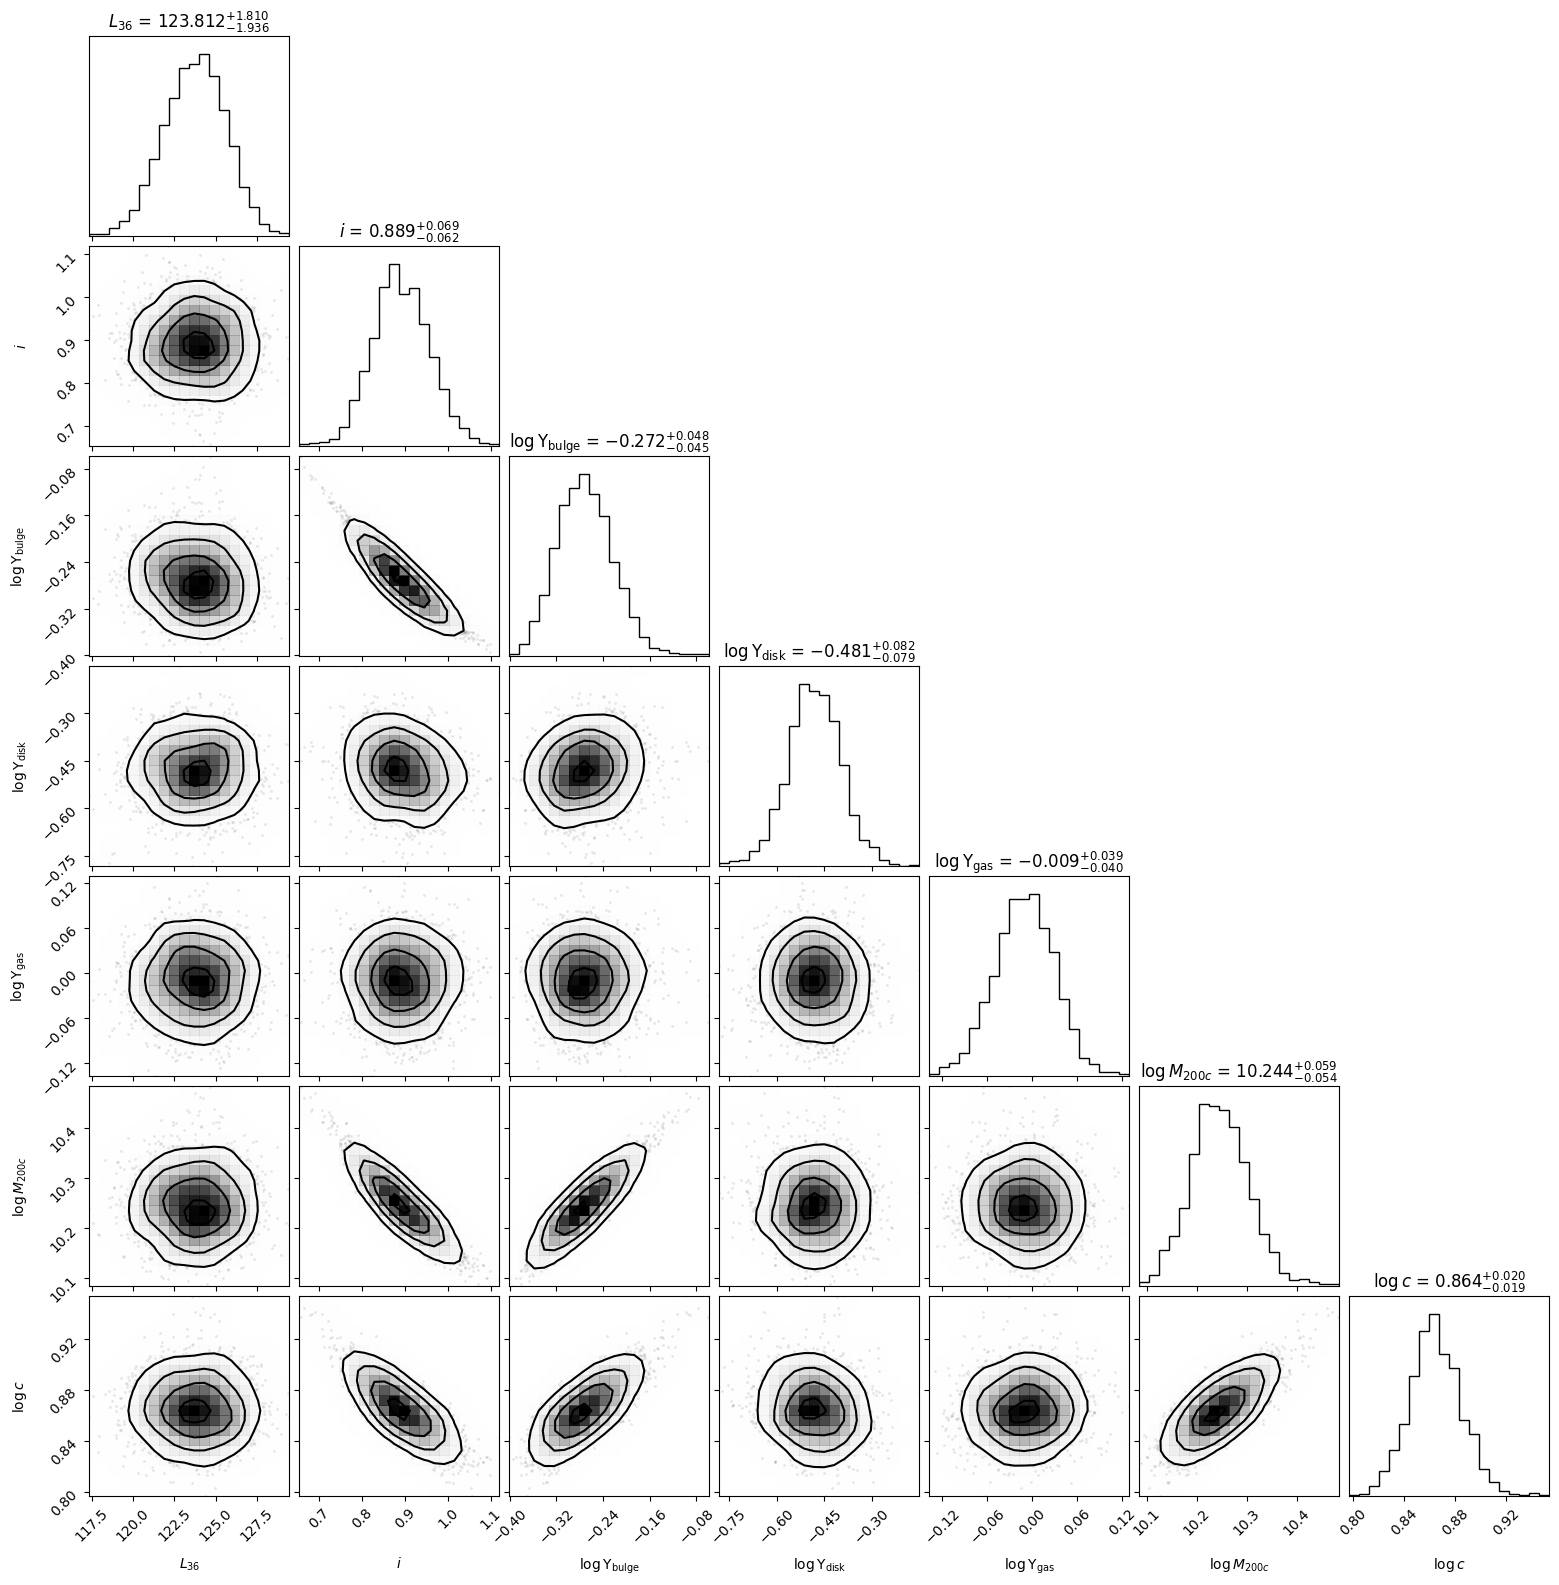

In [ ]:
current_labels = [name2label(name) for name in labelsCMOD]
fig = corner(dataCMOD, labels=current_labels, show_titles=True, title_fmt=".3f", smooth=1)
fig.show()


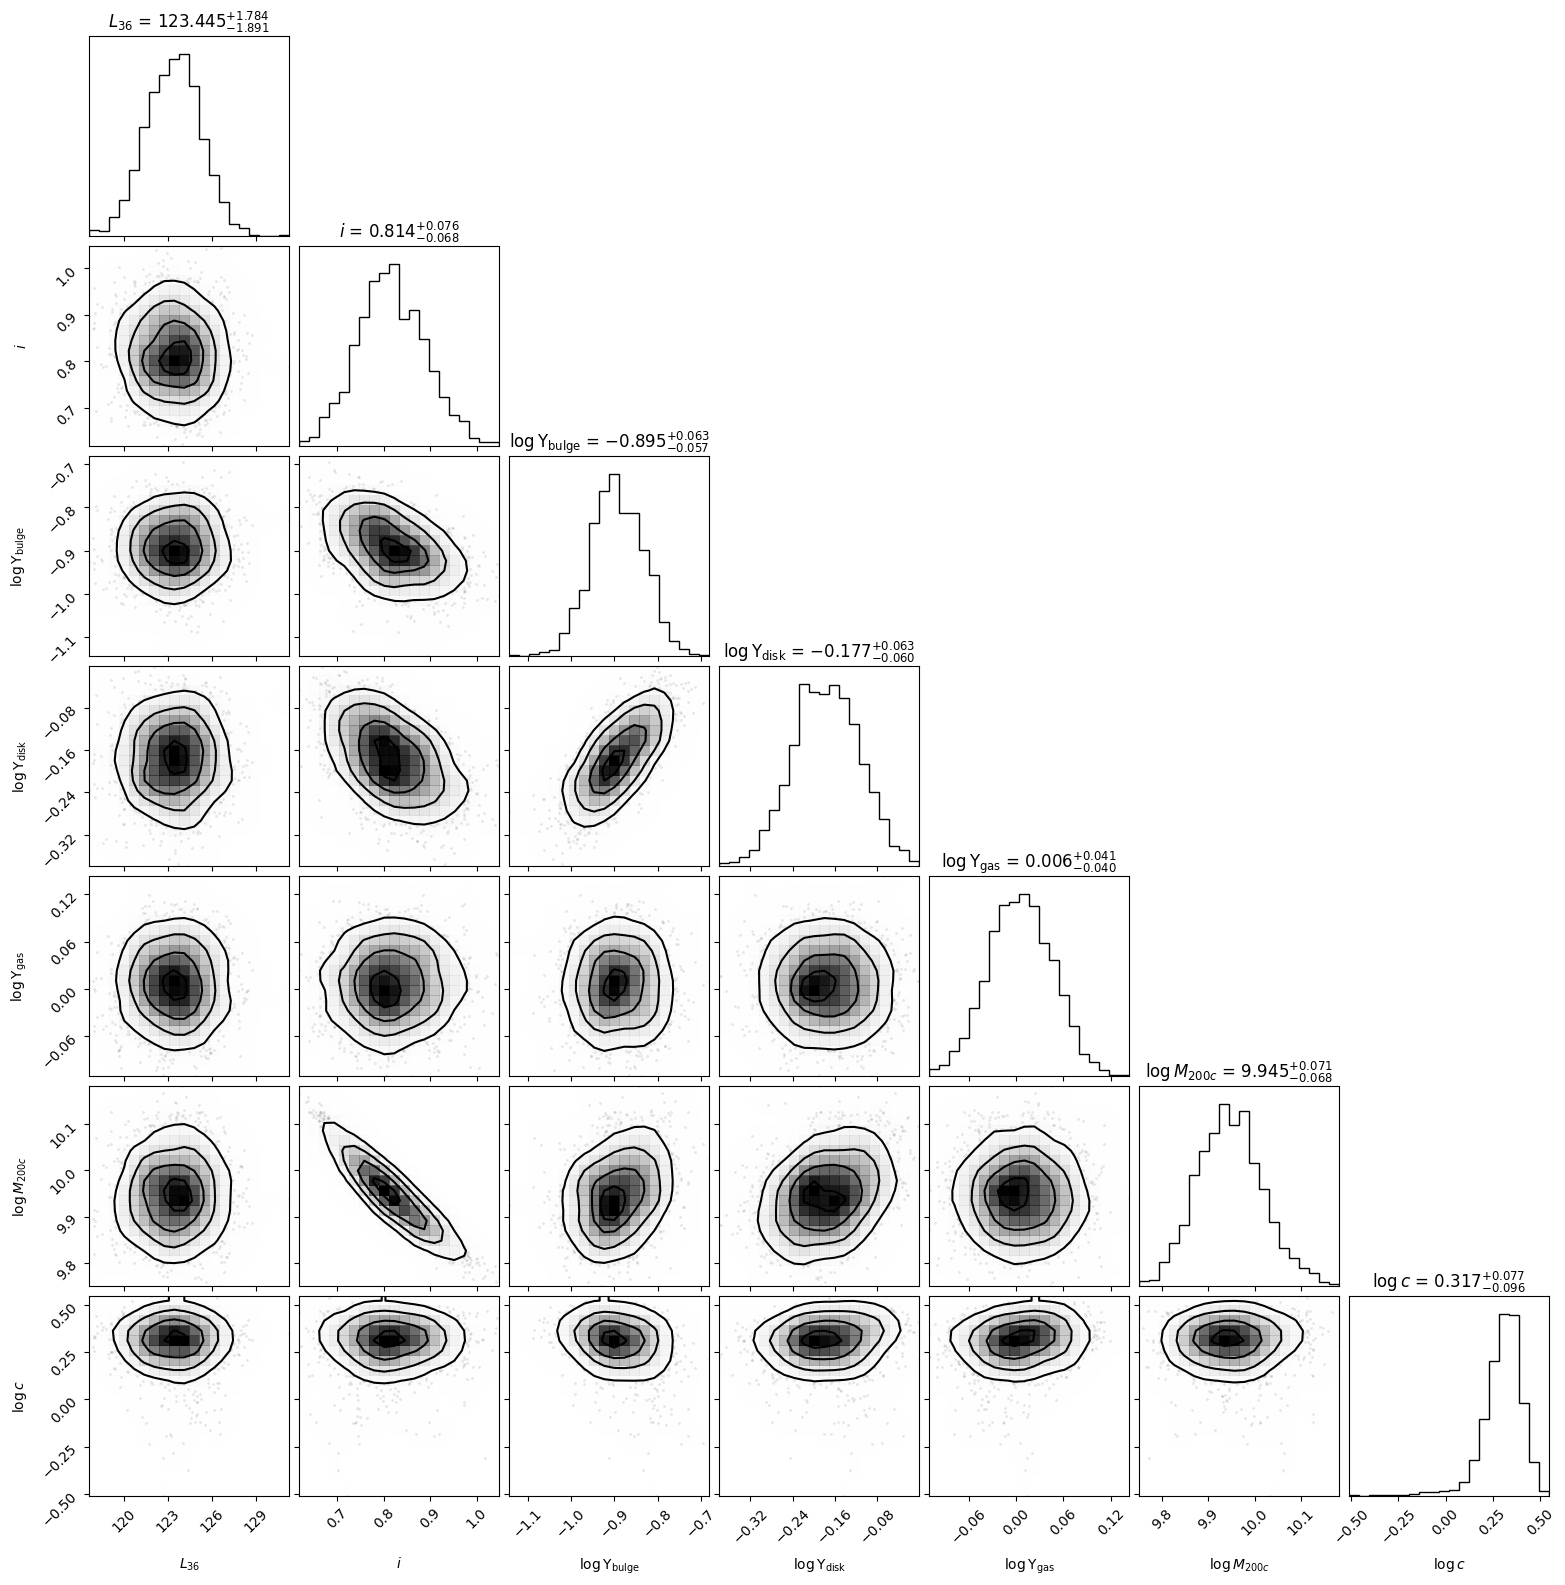

In [ ]:
current_labels = [name2label(name) for name in labelsBUR]
fig = corner(dataBUR, labels=current_labels, show_titles=True, title_fmt=".3f", smooth=1)
fig.show()


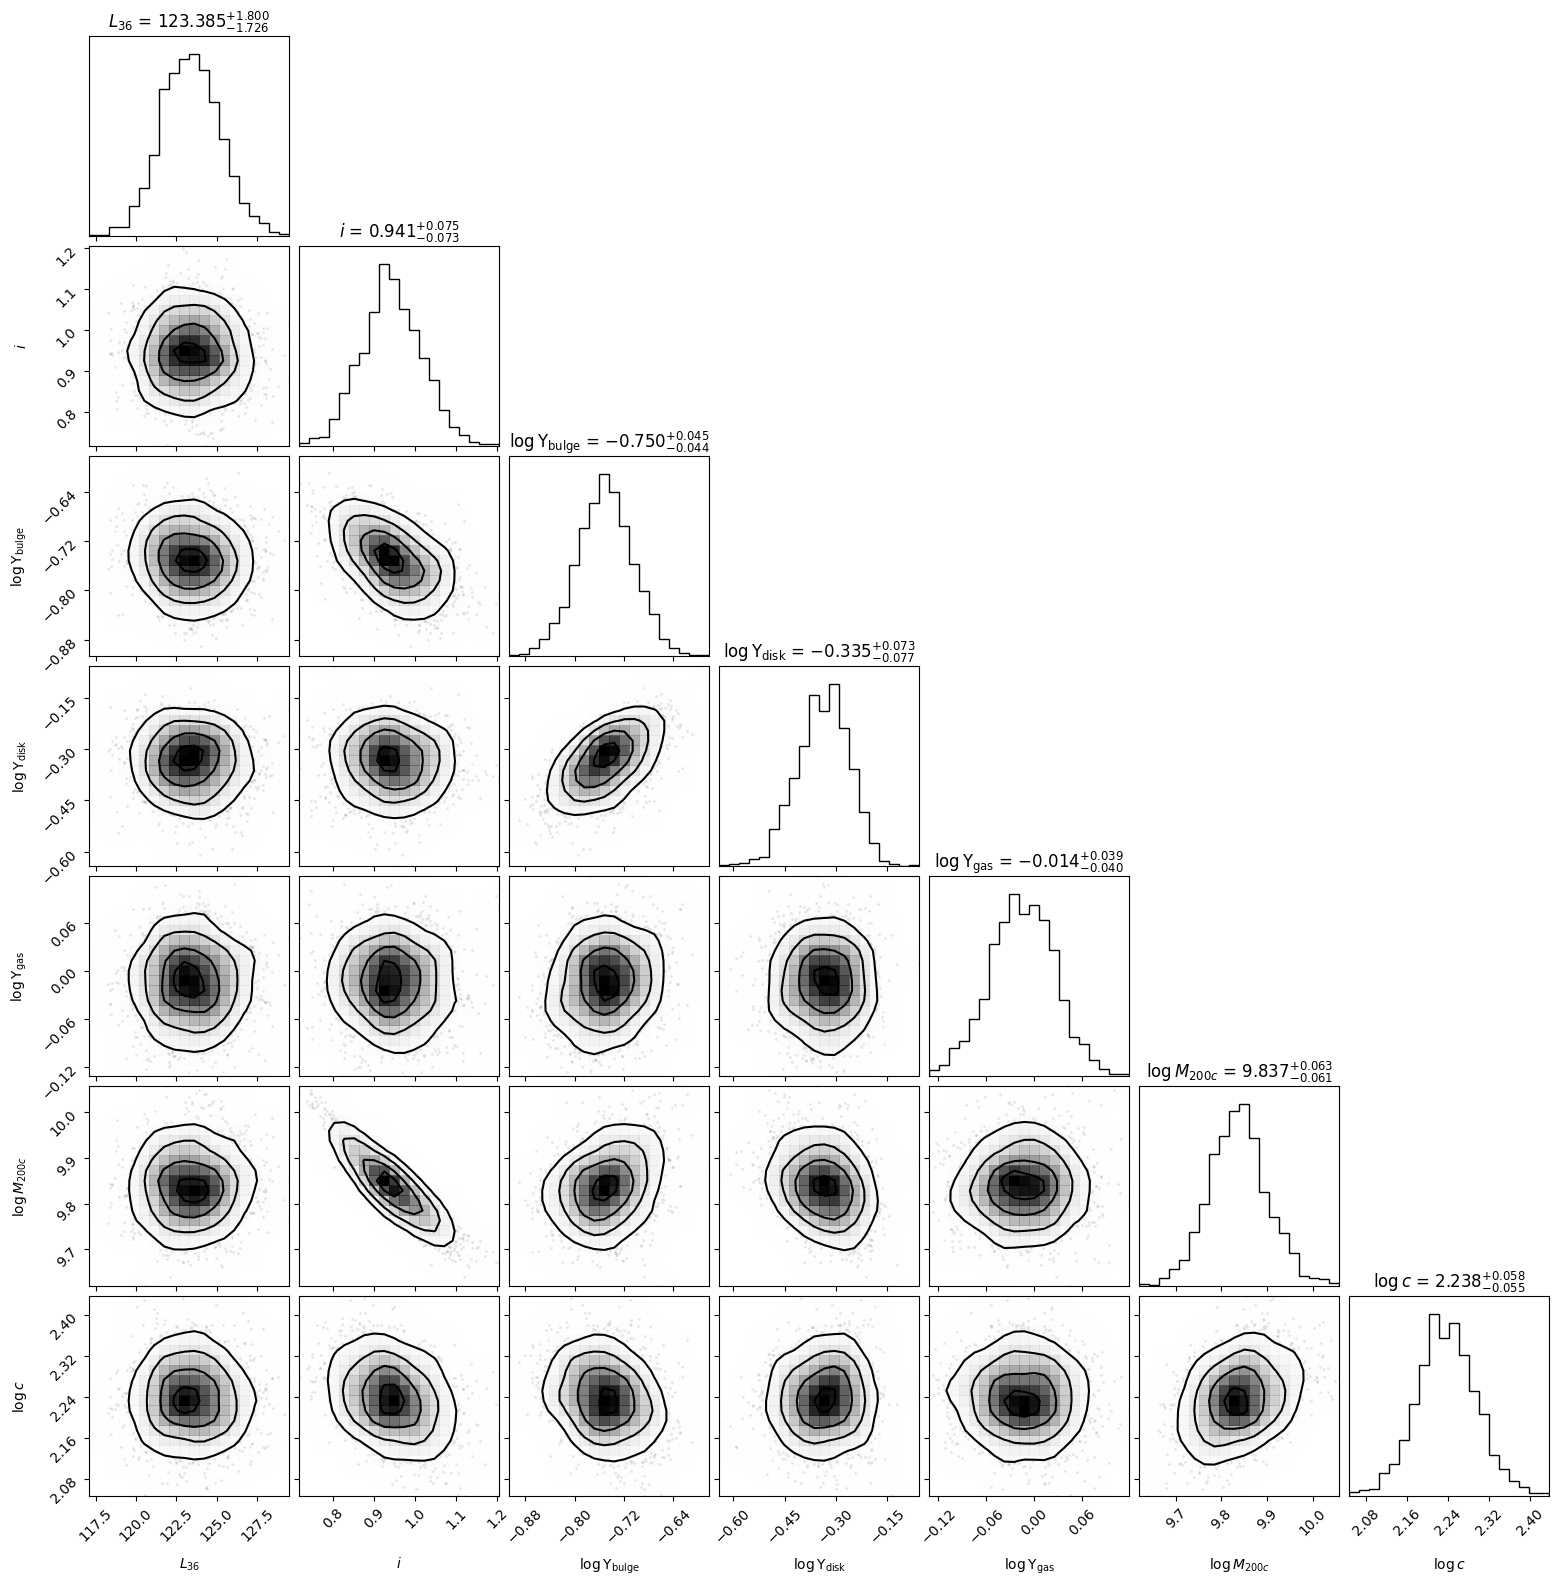

In [ ]:
current_labels = [name2label(name) for name in labelsPISO]
fig = corner(dataPISO, labels=current_labels, show_titles=True, title_fmt=".3f", smooth=1)
fig.show()


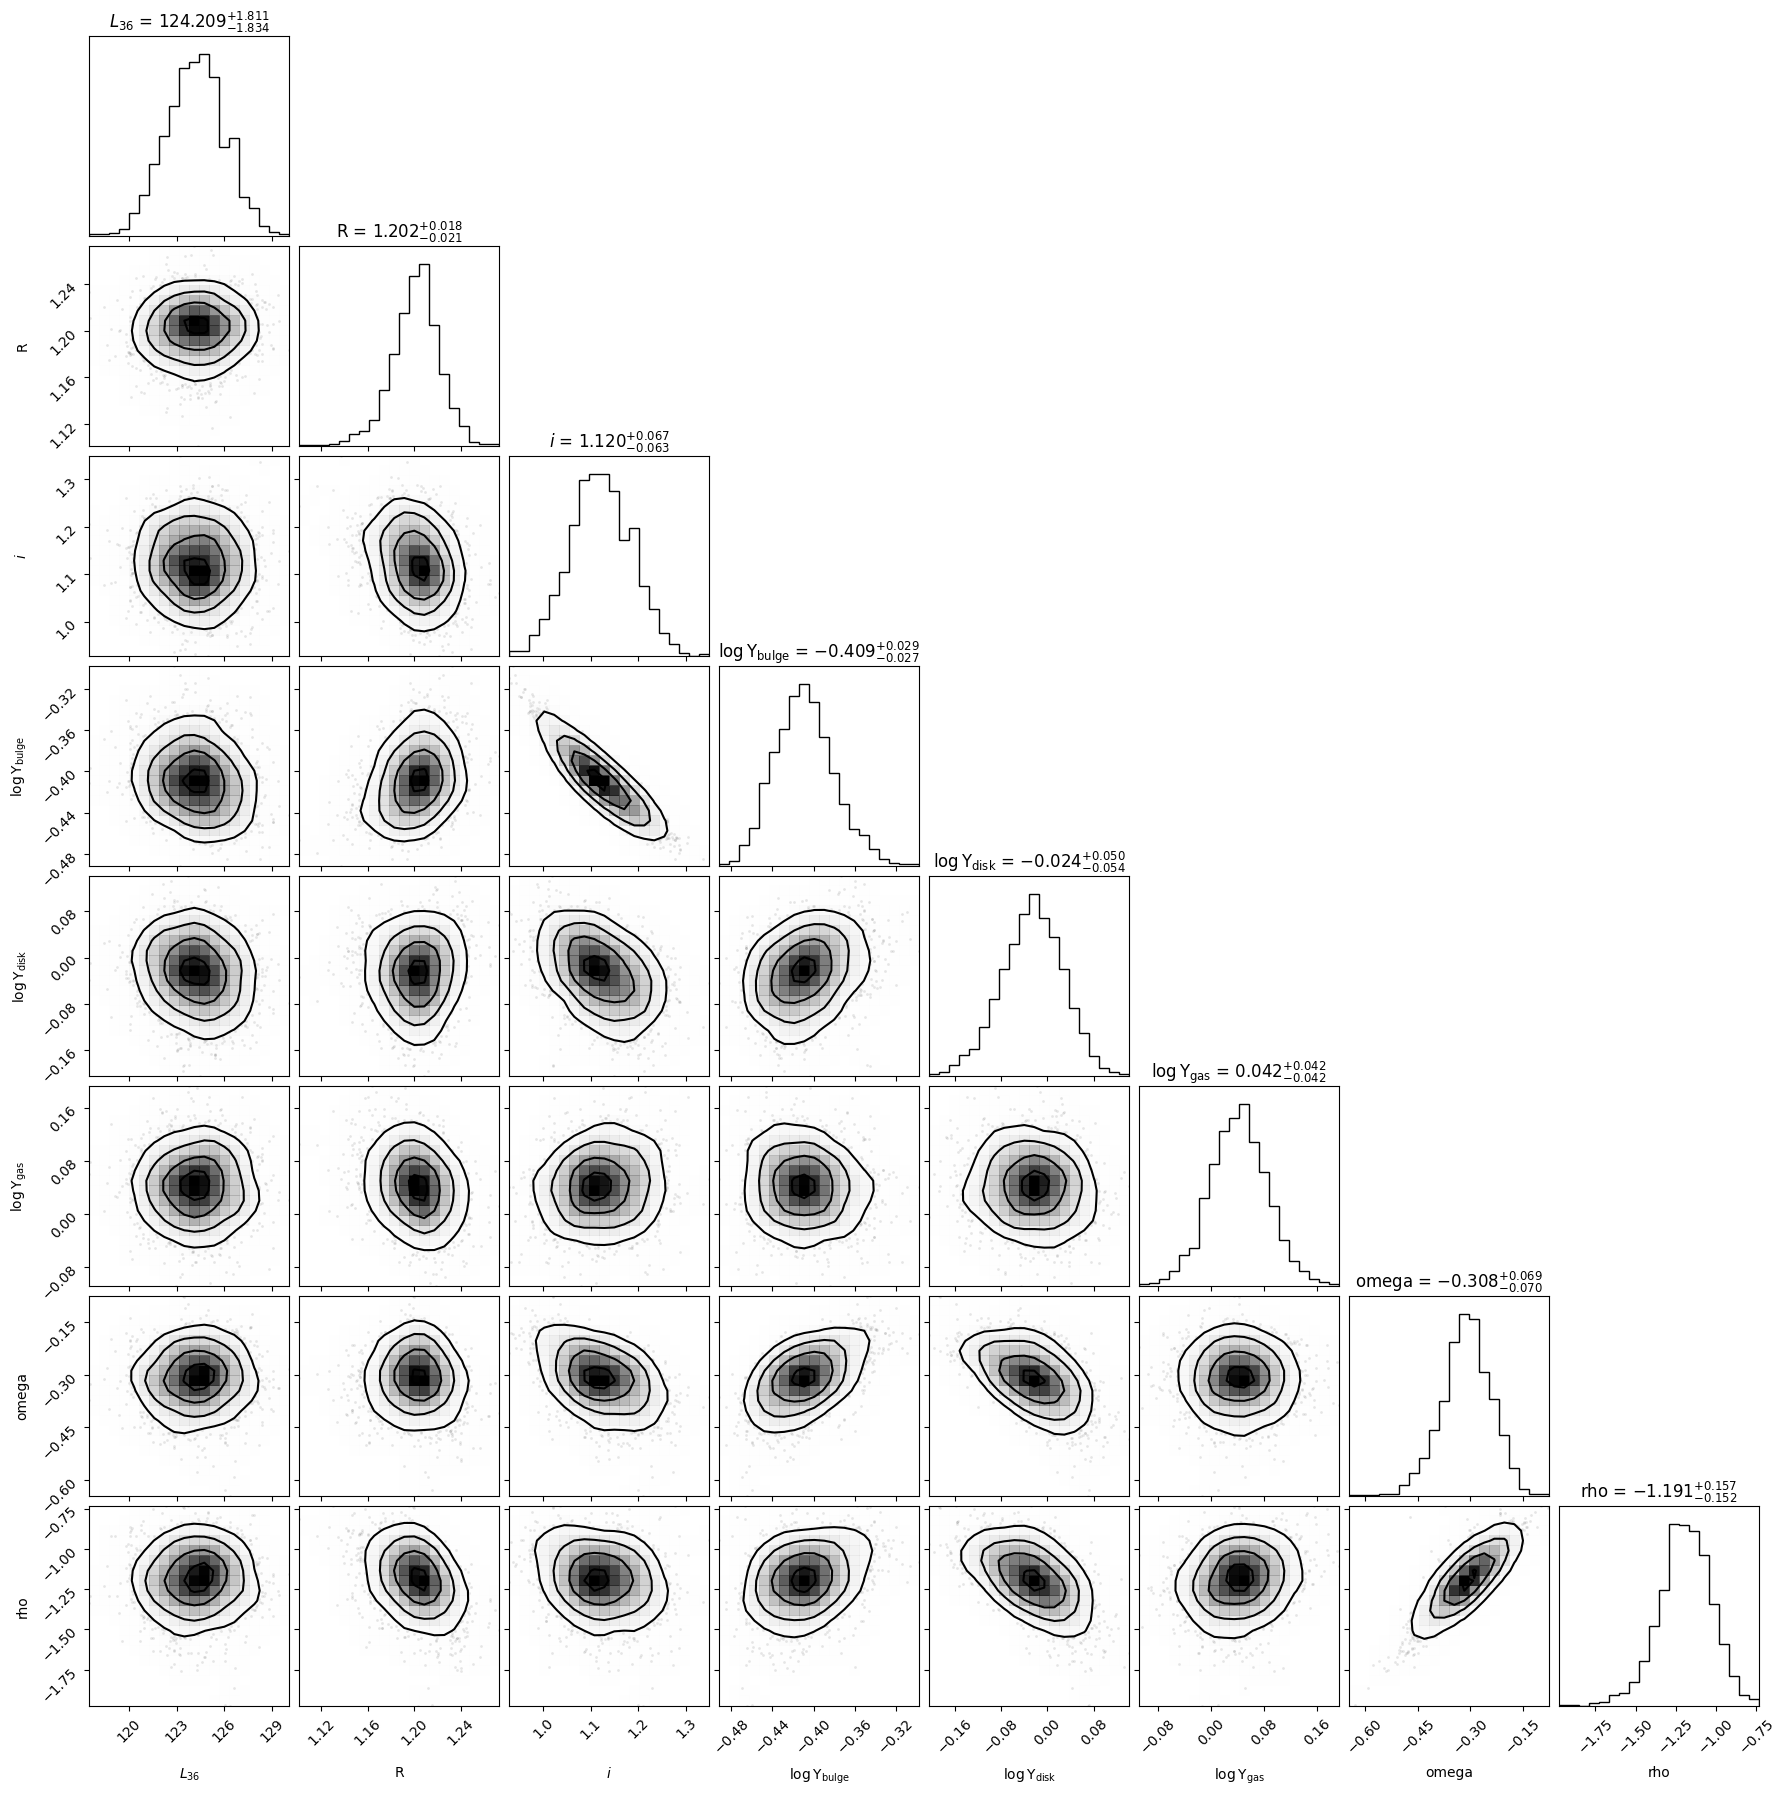

In [ ]:
current_labels = [name2label(name) for name in labelsBEC]
fig = corner(dataBEC, labels=current_labels, show_titles=True, title_fmt=".3f", smooth=1)
fig.show()


# BIC

In [ ]:
#BIC

#Minimum Loss calculator


log_posteriorNFW = -mcmcNFW.get_extra_fields()["potential_energy"]
log_posteriorFDM = -mcmcFDM.get_extra_fields()["potential_energy"]
log_posteriorCMOD = -mcmcCMOD.get_extra_fields()["potential_energy"]
log_posteriorBUR = -mcmcBUR.get_extra_fields()["potential_energy"]
log_posteriorRAR = -mcmcRAR.get_extra_fields()["potential_energy"]
log_posteriorPISO = -mcmcPISO.get_extra_fields()["potential_energy"]
log_posteriorBEC = -mcmcBEC.get_extra_fields()["potential_energy"]

#Parameters
#NFW = 2 - 133389.42
#FDM = 5 - 133403.61
#CMOD = 2
#BUR = 2
#RAR = 2
#PISO = 2
#BEC = 3


def BICValue(parameters, r, log_posterior):
  k = parameters
  n = r.size
  #return k * jnp.log(n) + n * jnp.log(minLoss)
  return k * jnp.log(n) - 2 * np.max(log_posterior)

print("NFW:", BICValue(2, galaxy_data["r"], log_posteriorNFW))
print("FDM:", BICValue(5, galaxy_data["r"], log_posteriorFDM))
print("CMOD:", BICValue(2, galaxy_data["r"], log_posteriorCMOD))
print("BUR:", BICValue(2, galaxy_data["r"], log_posteriorBUR))
print("RAR:", BICValue(2, galaxy_data["r"], log_posteriorRAR))
print("PISO:", BICValue(2, galaxy_data["r"], log_posteriorPISO))
print("BEC:", BICValue(3, galaxy_data["r"], log_posteriorBEC))
#Lower values are better

NFW: 609.71515
FDM: 270.71634
CMOD: 524.6273
BUR: 372.37515
RAR: 667.76495
PISO: 548.54407
BEC: 612.1904
